In [1]:
from numpy import array

tau = 2*pi


def line_plot_points(function1, u_bound, density = 100, color = 'red'):
    '''Plots points on a curve'''
    A = []
    for i in range(density+1):
        u = u_bound[0] * (density - i) + u_bound[1] * i
        u = u/density
        temp = function1(u)
#        print( type(temp[0]) )
#        print(type(1.0))
        if type(temp[0]) is sage.rings.complex_number.ComplexNumber:
            break
        A.append( temp )
#        print(u, function(u), type(function(u)[0]))
#    print(A)
    return point3d(A, color = color, size = 20) 


def surface_plot(function2, u_bound, v_bound, density = 50):
    '''Plots a surface'''
    A = []
    for i in range(density+1):
        u = u_bound[0] * (density - i) + u_bound[1] * i
        u = u/density
        for j in range(density+1):
            v = v_bound[0] * (density - j) + v_bound[1] * j
            v = v/density
            A.append( function2(u,v) )
    return point3d(A, size = 20)




def where_g(g, low, high, guesses = 20):
    '''Finds the highest point possible where g is defined'''
    if math.isnan(g(low)):
        raise Exception("g isn't defined at the lower bound")
    if not math.isnan(g(high)):
        return high
    a = low
    b = high
    #g isn't defined at b, but is at a
    iters = 2
    while iters < guesses:
        iters += 1
        defined = not math.isnan(g((a+b)/2))
        if defined:
            a = (a+b)/2
        else:
            b = (a+b)/2
    return a

def find_angle3(target, increment = 0.01, low = 0, high = 10, g = None, f = None, f_prime = None, guesses = 20):
    import math, random, sys
    '''Finds the angle of intersection between the geodesic and the meridian'''
    try:
#        Finds the upper bound on where g is defined.
        upper = where_g(g,low, high, guesses = 20)
    except:
        print(sys.exc_info())
        return 1000
    #Now find the root
    try:
        u_0 = find_root(lambda x: g(x)-target, low, upper)
    except:
        print(sys.exc_info())
        return 1000
#    print(n(u_0))
    u_1 = u_0 + (high-low)*increment
    v_0 = g(u_0)
    v_1 = g(u_1)
#    print(u_0,u_1,v_0,v_1)
    meridian_vec = vector([f_prime(u_0)* cos(v_0), f_prime(u_0)* sin(v_0),1])
    geodesic_vec = vector([f(u_1) * cos(v_1), f(u_1) * sin(v_1), u_1]) - vector([f(u_0) * cos(v_0), f(u_0) * sin(v_0), u_0])
#    print(meridian,geodesic)
#    print(geodesic_vec)
    dotproduct = meridian_vec.dot_product(geodesic_vec)
#    print(dotproduct)
    ratio = dotproduct/(norm(meridian_vec) * norm(geodesic_vec))
    temp = n(arccos(ratio)/tau)
    if math.isnan(temp):
        return 1000
    else:
        return temp
#   e.g. if the actual angle is pi/2 = tau/4, this returns 0.25



def deviation(numbers, target_mean):
    '''Square root of the average squared difference from a target'''
    the_sum = 0
    for x in numbers:
        the_sum += (x - target_mean)^2
    return n(sqrt(the_sum/len(numbers)))

def standard_deviation(numbers):
    '''Does NOT use sample variance'''
    the_sum = 0
    for x in numbers:
        the_sum += x
    the_mean = the_sum/len(numbers)
    return deviation(numbers, the_mean)
    
def should_stop():
    '''Returns true if the word "stop" is in the file often_overwritten.txt'''
    f = open("often_overwritten.txt","r")
    stop = "stop" in f.read().lower()
# i.e. the variable stop records whether the word "stop" is in the file, ignoring case
    f.close()
    return stop


def integrand(s, f, f_prime, C):
    temp = C/f(s) * sqrt((1+ f_prime(s)^2)/(f(s)^2-C^2) )
    if type(temp) is sage.rings.complex_number.ComplexNumber:
        return NaN
    return temp

In [13]:
import numpy as np

def amoeba(f, n, initial_point, initial_step, goal = -10^6, will_plot3d = False , x_range = (-1,1), y_range = (-1,1)):
    '''n is the dimension
    initial_point is a numpy array of length n
    f is the loss function. It takes numpy vectors of length n as input
    initial_step is how long the sides of the initial simplex should be 
    goal is a number we want the minimum to go below
    x_range and y_range only determine where the plot is'''
    import numpy as np
    vertices = []
    evals = 0 #How many times we call f
    vertices.append( (initial_point, f(initial_point) ) ) #Store the point and its function value
    evals += 1
    #Now we go in each of the n orthogonal basis directions to get a vertex
    for i in range(n):
        perturbation = np.zeros(n) #the n-dimensional zero vector
        perturbation[i] = initial_step #Give it a direction
        temp_point = initial_point + perturbation
        vertices.append( (temp_point, f(temp_point) ) ) #Add the vertex to the list
        evals += 1
    #Note to self: vertices has n+1 elements, not n! 
    iters = 0
    if will_plot3d:
        aux_f = lambda x,y: f( np.array([x,y]) )
        P = plot3d(aux_f, x_range, y_range, opacity = 1)
    while not should_stop() and vertices[0][1] > goal and standard_deviation( [vertex[1] for vertex in vertices] ) > 10^-9:
        #Stop if we get a point below the goal, or if the user tells it to stop, or if we're not making much progress
#        print(vertices)
        iters += 1
        if will_plot3d:
            poly = Polyhedron( [tuple(vertices[i][0]) + (vertices[i][1],) for i in range(n+1)])
            P+= plot(poly, opacity = 0.25, color = 'yellow')
        vertices, evals = amoeba_iterate(f, n, vertices, evals)
        vertices.sort(key = lambda x: x[1]) #Sort so that we can find the smallest element in the while loop
        print("Independent variables at current minimum:", repr(vertices[0][0]))
        print("Dependent variable at current minimum:", vertices[0][1])
        print("Standard deviation of dependent variables of all", n+1, "vertices:",
              standard_deviation( [vertex[1] for vertex in vertices] ) )
        print("Function evaluations:", evals)
    if will_plot3d:
        poly = Polyhedron( [tuple(vertices[i][0]) + (vertices[i][1],) for i in range(n+1)])
        P+= plot(poly, opacity = 0.25, color = 'yellow')
    print("Done.")
    print("Independent variables at current minimum:", repr(vertices[0][0]))
    print("Dependent variable at current minimum:", vertices[0][1])
    print("Standard deviation of dependent variables of all", n+1, "vertices:",
              standard_deviation( [vertex[1] for vertex in vertices] ) )
    print("Function evaluations:", evals)
    if will_plot3d:
        show(P)
        
    
    
def amoeba_iterate(f, n, vertices, evals):
    import numpy as np
    vertices.sort(key = lambda x: x[1]) #Sort the vertices from least value of f to greatest
    V, f_V = vertices[n] #Remember the list is indexed from 0 to n
    C = np.zeros(n)
    for i in range(n): #i.e. 0,1,...,n-1
        C = C + vertices[i][0]
    C = C / n #C is the centroid of the other n points
    V_prime = C + (C-V) #Reflect V over C
    f_V_prime = f(V_prime)
    evals += 1
    if f_V_prime < vertices[0][1]: #V_prime is the best point so far
        V_prime_prime = C + 2* (C-V) #Reflect V over C, twice as far
        f_V_prime_prime = f(V_prime_prime)
        evals += 1
        if f_V_prime_prime < f_V_prime: #Use whichever one is better
            vertices[n] = (V_prime_prime,f_V_prime_prime)
        else:
            vertices[n] = (V_prime,f_V_prime)
        return vertices, evals
    elif f_V_prime < vertices[n-1][1]: #The old second-highest point is now the highest point
        vertices[n] = (V_prime,f_V_prime)
        return vertices, evals
    else: #Reflecting didn't get to a point smaller than the second-highest point
        if f_V_prime < f_V: #X is the better of V and V_prime
            X = V_prime
            f_X = f_V_prime
        else:
            X = V
            f_X = f_V 
        X_prime = (C + X)/2 #Contract X toward the centroid
        f_X_prime = f(X_prime)
        evals += 1
        if f_X_prime < f_V: #Going toward the centroid makes f smaller
            vertices[n] = (X_prime,f_X_prime)
            return vertices, evals
        else: #Going toward the centroid does not make f smaller, which is weird
            #So we move every point halfway towards the lowest point
            L = vertices[0][0] #the lowest point
            for i in range(1,n+1): #1,2,...,n
                Y = vertices[i][0]
                Z = (Y + L) / 2
                vertices[i] = (Z, f(Z) )
                evals += 1
            return vertices, evals

In [4]:
def get_loss_function_quintic(maybe_inverse_slopes = ( 0.5, 1, 2),
    #These are the initial angles? slopes? inverse slopes? of the geodesics.
    goal = 0.20,
    meridian = tau/6,
    low = 0,
    high = 100 ):
    '''Given parameters (the maybe inverse slopes).
    Returns a loss function acceptable to the amoeba'''
    return lambda coeff_array: loss_function_quintic_params( coeff_array, maybe_inverse_slopes, goal, meridian, low, high)
    

def loss_function_quintic_params( coeff_array, maybe_inverse_slopes, goal, meridian, low, high):
    '''Builds a quintic polynomial from the array of coefficients.
    Then calculates some geodesics with the initial directions
    of the maybe inverse slopes. 
    Finds the intersection angles between these geodesics and a 
    particular meridian. 
    Returns a number indicating how much the angles deviate from
    a target angle'''
    

    

    var('t')
   
    poly(t) = coeff_array[0] + coeff_array[1]*t + coeff_array[2]*t^2 + coeff_array[3]*t^3 + coeff_array[4]*t^4  + coeff_array[5]*t^5  
   
#    print(ratl)
    
   
    poly_prime = lambda t: derivative(poly)(t)
    
    
    
    angles = []

    for C in maybe_inverse_slopes:
        
        g = lambda x: numerical_integral(integrand(s, poly, poly_prime, C) , (0, x))[0]
        var('s')
        angles.append(find_angle3(meridian, 0.0001,low = low, high = high, g = g, f = poly, f_prime = poly_prime, guesses = 20))
#    print(angles)
    return deviation(angles, goal)


In [5]:
def plot_quintic(coeff_array, scaling = 1, show_3d=False, my_training_maybe_inverse_slopes = None, high = 10):




    var('t')

    temp(t) = coeff_array[0] + coeff_array[1]*t + coeff_array[2]*t^2 + coeff_array[3]*t^3 + coeff_array[4]*t^4  + coeff_array[5]*t^5  
    
    poly(t) = temp(t*scaling) / scaling

    poly_prime = lambda t: derivative(poly)(t)
    
    print(poly)


    low = 0
    high = high/scaling

    #show(plot(ratl,low, high))

    goal = 0.2

    meridian = tau/6

    P = surface_plot(lambda u, v : (poly(u) * cos(v), poly(u) * sin(v), u),   (low, high),   (0,tau), density = 50)


#def integrand2(s):
#    temp = C/f(s) * sqrt((1+ f_prime(s)^2)/(f(s)^2-C^2) )
#    if type(temp) is sage.rings.complex_number.ComplexNumber:
#        return NaN
#    return temp
    g = lambda x: numerical_integral(integrand(s, poly, poly_prime, C) , (0, x))[0]

    training_angles = []

    for C in my_training_maybe_inverse_slopes:

        temp = find_angle3(meridian, 0.0001,low = low, high = high, g = g, f = poly, f_prime = poly_prime)
        training_angles.append(temp)
        print(temp)

        var('u')
        P += line_plot_points(lambda u: (poly(u) * cos(g(u)), poly(u) * sin(g(u)), u), (low, high), color = 'red', density = 200)


    print()
    print("Deviation of training angles:", deviation(training_angles, goal))


    print()
    print()
    
    my_testing_maybe_inverse_slopes = []
    
    for i in range(len(my_training_maybe_inverse_slopes)-1):
        my_testing_maybe_inverse_slopes.append( 0.5 * ( my_training_maybe_inverse_slopes[i] + my_training_maybe_inverse_slopes[i+1]) )
        

    testing_angles = []

    for C in my_testing_maybe_inverse_slopes:

        temp = find_angle3(meridian, 0.0001,low = low, high = high, g = g, f = poly, f_prime = poly_prime)
        testing_angles.append(temp)
        print(temp)

        var('u')
        P += line_plot_points(lambda u: (poly(u) * cos(g(u)), poly(u) * sin(g(u)), u), (low, high), color = 'orange', density = 200)



    print()
    print("Deviation of testing angles:", deviation(testing_angles, goal))

    P += line_plot_points(lambda u: (poly(u) * cos(meridian), poly(u) * sin(meridian), u), (low, high), color = 'yellow', density = 200)

    if show_3d:
        show(P)

Let's try $y = x - x^2$

In [8]:
temp_loss_function = get_loss_function_quintic(maybe_inverse_slopes = ( 0.5, 1, 2),
    goal = 0.20,
    meridian = tau/6,
    low = 0,
    high = 100 )
amoeba(f = temp_loss_function, n = 6, initial_point=array([0,1,-1,0,0,0]),  initial_step = 0.01 )

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907489c0>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907537c0>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690753a00>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969075e880>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and th

In [11]:
plot_quintic( array([ 0,  1, -1,  0,  0,  0]) ,my_training_maybe_inverse_slopes = 
                                    ( 0.5, 1, 2),
          show_3d = True, high = 3)

t |--> -t^2 + t
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96915478c0>)
1000
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969073ff80>)
1000
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9691534a40>)
1000

Deviation of training angles: 999.800000000000


(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9691540a80>)
1000
(<

Graphics3d Object

Oh, I bet it doesn't like starting at the pole. Let's give it some space with $y = 1 + x - x^2$.

In [12]:
temp_loss_function = get_loss_function_quintic(maybe_inverse_slopes = ( 0.5, 1, 2),
    goal = 0.20,
    meridian = tau/6,
    low = 0,
    high = 100 )
amoeba(f = temp_loss_function, n = 6, initial_point=array([1,1,-1,0,0,0]),  initial_step = 0.01 )

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907633c0>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690763640>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690763400>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690763d00>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and th

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969076ab80>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969076a200>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690ef5c40>)
Independent variables:  array([ 1,  1, -1,  0,  0,  0])
Dependent variable: 577.234800405448
Standard deviation of dependent variables of all 7 vertices: 9.38825476644071e-9
Function evaluations: 27
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely 

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969105fd80>)
Independent variables:  array([ 1.00000996,  0.99772645, -0.99060689, -0.00310689, -0.00211152,
       -0.00630423])
Dependent variable: 577.234800385180
Standard deviation of dependent variables of all 7 vertices: 9.64282777231192e-9
Function evaluations: 46
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969105fd80>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969078dec0>)
Independent variables:  array([ 1.00000879e+00,  9.84987

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969076cf40>)
Independent variables:  array([ 1.00008669,  0.90213361, -0.93545127, -0.01798213,  0.01429175,
       -0.0581675 ])
Dependent variable: 577.234800092041
Standard deviation of dependent variables of all 7 vertices: 6.40632149178661e-8
Function evaluations: 66
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969079fe40>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969079f840>)
Independent variables:  array([ 1.00011401,  0.84749714,

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96906d5a80>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690a420c0>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969077cec0>)
Independent variables:  array([ 1.0002804 ,  0.58624723, -0.78102715, -0.02529263,  0.07659599,
       -0.19243349])
Dependent variable: 577.234799489474
Standard deviation of dependent variables of all 7 vertices: 8.89791137342305e-8
Function evaluations: 87
(<class 'TypeError'>, TypeError("ufunc 'isnan' not suppo

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690a42840>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907f2540>)
Independent variables:  array([ 1.0002944 ,  0.57142506, -0.77432516, -0.02598541,  0.08332461,
       -0.19965259])
Dependent variable: 577.234799471904
Standard deviation of dependent variables of all 7 vertices: 2.96877054236716e-8
Function evaluations: 105
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690767140>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supp

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907a0480>)
Independent variables:  array([ 1.0002944 ,  0.57142506, -0.77432516, -0.02598541,  0.08332461,
       -0.19965259])
Dependent variable: 577.234799471904
Standard deviation of dependent variables of all 7 vertices: 1.00772883924529e-8
Function evaluations: 123
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96910b8140>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96910b8800>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supp

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969077e8c0>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9690782280>)
Independent variables:  array([ 1.0002859 ,  0.50482557, -0.76668953, -0.01316413,  0.082659  ,
       -0.18683573])
Dependent variable: 577.234799416593
Standard deviation of dependent variables of all 7 vertices: 1.29408084260769e-8
Function evaluations: 142
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969077e680>)
Independent variables:  array([ 1.0002859 ,  0.50482557

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907baa80>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907a7200>)
Independent variables:  array([ 1.00027028,  0.41256137, -0.75592925,  0.00569223,  0.07912232,
       -0.16702776])
Dependent variable: 577.234799385888
Standard deviation of dependent variables of all 7 vertices: 1.07191256813466e-9
Function evaluations: 162
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969077f440>)
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supp

In [16]:
plot_quintic( array([ 1.00027028,  0.41256137, -0.75592925,  0.00569223,  0.07912232,
       -0.16702776]) ,my_training_maybe_inverse_slopes = 
                                    ( 0.5, 1, 2),
          show_3d = True, high = 2)

t |--> -0.16702776*t^5 + 0.07912232*t^4 + 0.00569223*t^3 - 0.75592925*t^2 + 0.41256137*t + 1.00027028
0.170577746487479
0.198989624758330
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9691440940>)
1000

Deviation of training angles: 577.234799386030


0.178942676905274
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9691421400>)
1000

Deviation of testing angles: 706.965359987111


Graphics3d Object

OK, so it's not happy with a maybe inverse slope of 2.

In [17]:
temp_loss_function = get_loss_function_quintic(maybe_inverse_slopes = ( 0.25, 0.5, 0.75, 1),
    goal = 0.20,
    meridian = tau/6,
    low = 0,
    high = 100 )
amoeba(f = temp_loss_function, n = 6, initial_point=array([1,1,-1,0,0,0]),  initial_step = 0.01 )

Independent variables at current minimum: array([ 1,  1, -1,  0,  0,  0])
Dependent variable at current minimum: 0.0462484200913467
Standard deviation of dependent variables of all 7 vertices: 0.000271172467595717
Function evaluations: 8
Independent variables at current minimum: array([ 1,  1, -1,  0,  0,  0])
Dependent variable at current minimum: 0.0462484200913467
Standard deviation of dependent variables of all 7 vertices: 0.000218042281278985
Function evaluations: 9
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96910f0900>)
Independent variables at current minimum: array([ 1,  1, -1,  0,  0,  0])
Dependent variable at current minimum: 0.0462484200913467
Standard deviation of dependent variables of all 7 vertices: 0.000245731056601258
Function evaluations: 17
(<class 'TypeError'>, TypeError("ufunc 'isnan' not suppor

Independent variables at current minimum: array([ 1,  1, -1,  0,  0,  0])
Dependent variable at current minimum: 0.0462484200913467
Standard deviation of dependent variables of all 7 vertices: 0.0000666594169019738
Function evaluations: 56
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96914bc100>)
Independent variables at current minimum: array([ 1,  1, -1,  0,  0,  0])
Dependent variable at current minimum: 0.0462484200913467
Standard deviation of dependent variables of all 7 vertices: 0.0000631427798121735
Function evaluations: 58
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9691376e80>)
Independent variables at current minimum: array([ 1,  1, -1,  0,

Independent variables at current minimum: array([ 1.00000906e+00,  1.00082997e+00, -1.00111447e+00, -3.75114653e-03,
       -3.98097560e-05, -9.69040878e-05])
Dependent variable at current minimum: 0.0460610490735330
Standard deviation of dependent variables of all 7 vertices: 0.0000770826873442838
Function evaluations: 93
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9691089580>)
Independent variables at current minimum: array([ 1.00000183e+00,  1.00054572e+00, -1.00217033e+00, -2.26520587e-03,
       -2.84969857e-05, -5.51681086e-05])
Dependent variable at current minimum: 0.0460607192219309
Standard deviation of dependent variables of all 7 vertices: 0.0000760828595017557
Function evaluations: 95
Independent variables at current minimum: array([ 1.00000501e+00,  9.98582840e-01, -1.00314556e+00, -3.43085648e-03,
     

(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9691500580>)
Independent variables at current minimum: array([ 1.00018032e+00,  1.00146848e+00, -1.08631052e+00, -9.68345927e-02,
       -7.94399342e-04, -1.94626125e-03])
Dependent variable at current minimum: 0.0385682845145203
Standard deviation of dependent variables of all 7 vertices: 0.00100702937804028
Function evaluations: 131
Independent variables at current minimum: array([ 1.00024721,  1.00408676, -1.11595263, -0.13007391, -0.00113089,
       -0.00273952])
Dependent variable at current minimum: 0.0367937546103782
Standard deviation of dependent variables of all 7 vertices: 0.00128098228567227
Function evaluations: 133
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9691500e00>)
Independent variables at current minimum: array([ 1.00024721,  1.00408

Independent variables at current minimum: array([ 1.00024721,  1.00408676, -1.11595263, -0.13007391, -0.00113089,
       -0.00273952])
Dependent variable at current minimum: 0.0367937546103782
Standard deviation of dependent variables of all 7 vertices: 0.000588435644075273
Function evaluations: 167
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9690764700>)
Independent variables at current minimum: array([ 1.00024721,  1.00408676, -1.11595263, -0.13007391, -0.00113089,
       -0.00273952])
Dependent variable at current minimum: 0.0367937546103782
Standard deviation of dependent variables of all 7 vertices: 0.000574826334122809
Function evaluations: 169
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9690764200>)
Independent variables at current minimum: array([ 1.00024721,  1.00408676, -1.11595263, -0.1

Independent variables at current minimum: array([ 1.00024721,  1.00408676, -1.11595263, -0.13007391, -0.00113089,
       -0.00273952])
Dependent variable at current minimum: 0.0367937546103782
Standard deviation of dependent variables of all 7 vertices: 174.915685568675
Function evaluations: 205
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9691706200>)
Independent variables at current minimum: array([ 1.00024721,  1.00408676, -1.11595263, -0.13007391, -0.00113089,
       -0.00273952])
Dependent variable at current minimum: 0.0367937546103782
Standard deviation of dependent variables of all 7 vertices: 174.915685567638
Function evaluations: 206
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9691706400>)
Independent variables at current minimum: array([ 1.00024721,  1.00408676, -1.11595263, -0.13007391,

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96915a1440>)
Independent variables at current minimum: array([ 1.00029912,  1.00628145, -1.13992387, -0.15697929, -0.00135374,
       -0.00328889])
Dependent variable at current minimum: 0.0356686862031247
Standard deviation of dependent variables of all 7 vertices: 0.000105915925082129
Function evaluations: 236
Independent variables at current minimum: array([ 1.00029912,  1.00628145, -1.13992387, -0.15697929, -0.00135374,
       -0.00328889])
Dependent variable at current minimum: 0.0356686862031247
Standard deviation of dependent variables of all 7 vertices: 0.000105795229204787
Function evaluations: 237
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casti

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907badc0>)
Independent variables at current minimum: array([ 1.00029935,  1.00628487, -1.14002617, -0.15709077, -0.00135443,
       -0.00329082])
Dependent variable at current minimum: 0.0356639683053440
Standard deviation of dependent variables of all 7 vertices: 0.0000162175138701697
Function evaluations: 266
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96907baf00>)
Independent variables at current minimum: array([ 1.00029935,  1.00628487, -1.14002617, -0.15709077, -0.00135443,
       -0.00329082])
Dependent variable at current minimum: 0.0356639683053440
Standard deviation of dependent variables of all 

Independent variables at current minimum: array([ 1.00029942,  1.00628595, -1.14008848, -0.15715466, -0.00135408,
       -0.00329044])
Dependent variable at current minimum: 0.0356612197325651
Standard deviation of dependent variables of all 7 vertices: 3.11204053867619e-6
Function evaluations: 296
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96911dbc00>)
Independent variables at current minimum: array([ 1.00029942,  1.00628595, -1.14008848, -0.15715466, -0.00135408,
       -0.00329044])
Dependent variable at current minimum: 0.0356612197325651
Standard deviation of dependent variables of all 7 vertices: 2.75975156709539e-6
Function evaluations: 298
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9691906640>)
Independent variables at current minimum: array([ 1.00029947,  1.00628876, -1.14010089, -0.15717146, -0.00135441,
       -0.00329114])
Dependent variable at current minimum: 0.0356606396150138
Standard deviation of dependent variables of all 7 vertices: 4.19694628137400e-7
Function evaluations: 328
Independent variables at current minimum: array([ 1.00029947,  1.00628876, -1.14010089, -0.15717146, -0.00135441,
       -0.00329114])
Dependent variable at current minimum: 0.0356606396150138
Standard deviation of dependent variables of all 7 vertices: 4.19692458832577e-7
Function evaluations: 329
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting

Independent variables at current minimum: array([ 1.00029944,  1.00628531, -1.14010303, -0.15716778, -0.001354  ,
       -0.00329037])
Dependent variable at current minimum: 0.0356605837969527
Standard deviation of dependent variables of all 7 vertices: 8.74809908810539e-8
Function evaluations: 358
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969078ab00>)
Independent variables at current minimum: array([ 1.00029944,  1.00628531, -1.14010303, -0.15716778, -0.001354  ,
       -0.00329037])
Dependent variable at current minimum: 0.0356605837969527
Standard deviation of dependent variables of all 7 vertices: 7.70524561726055e-8
Function evaluations: 360
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting

Independent variables at current minimum: array([ 1.00029923,  1.00625047, -1.14012988, -0.15713958, -0.00135016,
       -0.00328305])
Dependent variable at current minimum: 0.0356596855973373
Standard deviation of dependent variables of all 7 vertices: 1.98590223759566e-7
Function evaluations: 394
Independent variables at current minimum: array([ 1.00029923,  1.00625047, -1.14012988, -0.15713958, -0.00135016,
       -0.00328305])
Dependent variable at current minimum: 0.0356596855973373
Standard deviation of dependent variables of all 7 vertices: 1.98589303227679e-7
Function evaluations: 395
Independent variables at current minimum: array([ 1.00029919,  1.0062433 , -1.14013876, -0.15713764, -0.00134934,
       -0.0032815 ])
Dependent variable at current minimum: 0.0356593428062323
Standard deviation of dependent variables of all 7 vertices: 2.75549657277297e-7
Function evaluations: 397
Independent variables at current minimum: array([ 1.00029919,  1.0062433 , -1.14013876, -0.15713764,

Independent variables at current minimum: array([ 1.00027800e+00,  1.00273789e+00, -1.14283111e+00, -1.54296537e-01,
       -9.61979273e-04, -2.54420596e-03])
Dependent variable at current minimum: 0.0355706551515852
Standard deviation of dependent variables of all 7 vertices: 0.0000190329610605050
Function evaluations: 436
Independent variables at current minimum: array([ 1.00027800e+00,  1.00273789e+00, -1.14283111e+00, -1.54296537e-01,
       -9.61979273e-04, -2.54420596e-03])
Dependent variable at current minimum: 0.0355706551515852
Standard deviation of dependent variables of all 7 vertices: 0.0000190130345586087
Function evaluations: 437
Independent variables at current minimum: array([ 1.00026957e+00,  1.00136501e+00, -1.14387655e+00, -1.53184430e-01,
       -8.08426749e-04, -2.25186488e-03])
Dependent variable at current minimum: 0.0355372832906376
Standard deviation of dependent variables of all 7 vertices: 0.0000260556417174768
Function evaluations: 439
Independent variables 

Independent variables at current minimum: array([ 1.00022106e+00,  9.93361823e-01, -1.15000136e+00, -1.46680808e-01,
        7.73000751e-05, -5.65812940e-04])
Dependent variable at current minimum: 0.0353915943422135
Standard deviation of dependent variables of all 7 vertices: 1.37003051301059e-6
Function evaluations: 480
Independent variables at current minimum: array([ 1.00022106e+00,  9.93361823e-01, -1.15000136e+00, -1.46680808e-01,
        7.73000751e-05, -5.65812940e-04])
Dependent variable at current minimum: 0.0353915943422135
Standard deviation of dependent variables of all 7 vertices: 1.16854869034463e-6
Function evaluations: 482
Independent variables at current minimum: array([ 1.00022106e+00,  9.93361823e-01, -1.15000136e+00, -1.46680808e-01,
        7.73000751e-05, -5.65812940e-04])
Dependent variable at current minimum: 0.0353915943422135
Standard deviation of dependent variables of all 7 vertices: 8.92338544569909e-7
Function evaluations: 484
Independent variables at cur

Independent variables at current minimum: array([ 1.00022355e+00,  9.93716693e-01, -1.14978318e+00, -1.47005769e-01,
        3.41054166e-05, -6.48390893e-04])
Dependent variable at current minimum: 0.0353881328123256
Standard deviation of dependent variables of all 7 vertices: 8.28785920723272e-7
Function evaluations: 522
Independent variables at current minimum: array([ 1.00022355e+00,  9.93716693e-01, -1.14978318e+00, -1.47005769e-01,
        3.41054166e-05, -6.48390893e-04])
Dependent variable at current minimum: 0.0353881328123256
Standard deviation of dependent variables of all 7 vertices: 7.69090476638446e-7
Function evaluations: 523
Independent variables at current minimum: array([ 1.00022179e+00,  9.93402009e-01, -1.15004191e+00, -1.46760043e-01,
        6.71979831e-05, -5.85518776e-04])
Dependent variable at current minimum: 0.0353867801949165
Standard deviation of dependent variables of all 7 vertices: 9.99580949308439e-7
Function evaluations: 525
Independent variables at cur

Independent variables at current minimum: array([ 1.00022113e+00,  9.91084681e-01, -1.15389487e+00, -1.46301300e-01,
        1.69650627e-04, -4.04330217e-04])
Dependent variable at current minimum: 0.0352688641763746
Standard deviation of dependent variables of all 7 vertices: 0.0000205459147220876
Function evaluations: 560
Independent variables at current minimum: array([ 1.00022113e+00,  9.91084681e-01, -1.15389487e+00, -1.46301300e-01,
        1.69650627e-04, -4.04330217e-04])
Dependent variable at current minimum: 0.0352688641763746
Standard deviation of dependent variables of all 7 vertices: 0.0000209151276659682
Function evaluations: 561
Independent variables at current minimum: array([ 1.00022113e+00,  9.91084681e-01, -1.15389487e+00, -1.46301300e-01,
        1.69650627e-04, -4.04330217e-04])
Dependent variable at current minimum: 0.0352688641763746
Standard deviation of dependent variables of all 7 vertices: 0.0000170069002466784
Function evaluations: 562
Independent variables 

Independent variables at current minimum: array([ 1.00022259e+00,  9.90827892e-01, -1.15455263e+00, -1.46405014e-01,
        1.63263315e-04, -4.19563684e-04])
Dependent variable at current minimum: 0.0352379663834986
Standard deviation of dependent variables of all 7 vertices: 6.10219773567721e-6
Function evaluations: 591
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9692717300>)
Independent variables at current minimum: array([ 1.00022259e+00,  9.90827892e-01, -1.15455263e+00, -1.46405014e-01,
        1.63263315e-04, -4.19563684e-04])
Dependent variable at current minimum: 0.0352379663834986
Standard deviation of dependent variables of all 7 vertices: 5.35917037787353e-6
Function evaluations: 593
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9692797e40>)
Independent variables at current minimum: array([ 1.00022369e+00,  9.91045043e-01, -1.15435520e+00, -1.46561266e-01,
        1.41755730e-04, -4.60295754e-04])
Dependent variable at current minimum: 0.0352356252178587
Standard deviation of dependent variables of all 7 vertices: 9.78606066352492e-7
Function evaluations: 622
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96927a65c0>)
Independent variables at current minimum: array([ 1.00022369e+00,  9.91045043e-01, -1.15435520e+00, -1.46561266e-01,
        1.41755730e-04, -4.60295754e-04])
Dependent variable at current minimum: 0.0352356252178587
Sta

Independent variables at current minimum: array([ 1.00022486e+00,  9.91272196e-01, -1.15414602e+00, -1.46719194e-01,
        1.18840937e-04, -5.03681291e-04])
Dependent variable at current minimum: 0.0352346934299072
Standard deviation of dependent variables of all 7 vertices: 2.80957437992731e-7
Function evaluations: 654
Independent variables at current minimum: array([ 1.00022486e+00,  9.91272196e-01, -1.15414602e+00, -1.46719194e-01,
        1.18840937e-04, -5.03681291e-04])
Dependent variable at current minimum: 0.0352346934299072
Standard deviation of dependent variables of all 7 vertices: 3.05030019639653e-7
Function evaluations: 655
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969292dd80>)
Independent variables at current minimum: array([ 1.00022486e+00,  9.91272196e-01, -1.15414602e+00, -1.46719194e-01,
       

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9692999480>)
Independent variables at current minimum: array([ 1.00022486e+00,  9.91272196e-01, -1.15414602e+00, -1.46719194e-01,
        1.18840937e-04, -5.03681291e-04])
Dependent variable at current minimum: 0.0352346934299072
Standard deviation of dependent variables of all 7 vertices: 7.67358832606916e-8
Function evaluations: 685
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96929a6f00>)
Independent variables at current minimum: array([ 1.00022486e+00,  9.91272196e-01, -1.15414602e+00, -1.46719194e-01,
        1.18840937e-04, -5.03681291e-04])
Dependent variable at current minimum: 0.0352346934299072
Sta

Independent variables at current minimum: array([ 1.00022473e+00,  9.91244612e-01, -1.15417173e+00, -1.46699472e-01,
        1.21477705e-04, -4.98692812e-04])
Dependent variable at current minimum: 0.0352346740432601
Standard deviation of dependent variables of all 7 vertices: 1.98730283503333e-8
Function evaluations: 715
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9692b316c0>)
Independent variables at current minimum: array([ 1.00022478e+00,  9.91256202e-01, -1.15416090e+00, -1.46707573e-01,
        1.20344499e-04, -5.00836899e-04])
Dependent variable at current minimum: 0.0352346737314137
Standard deviation of dependent variables of all 7 vertices: 2.04887067931230e-8
Function evaluations: 717
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced

Independent variables at current minimum: array([ 1.00022422e+00,  9.91111192e-01, -1.15429649e+00, -1.46590230e-01,
        1.31945003e-04, -4.78922460e-04])
Dependent variable at current minimum: 0.0352340466572565
Standard deviation of dependent variables of all 7 vertices: 1.17781109985044e-7
Function evaluations: 750
Independent variables at current minimum: array([ 1.00022396e+00,  9.91043496e-01, -1.15435989e+00, -1.46534573e-01,
        1.37202559e-04, -4.68993600e-04])
Dependent variable at current minimum: 0.0352338166006252
Standard deviation of dependent variables of all 7 vertices: 1.52552452564040e-7
Function evaluations: 752
Independent variables at current minimum: array([ 1.00022396e+00,  9.91043496e-01, -1.15435989e+00, -1.46534573e-01,
        1.37202559e-04, -4.68993600e-04])
Dependent variable at current minimum: 0.0352338166006252
Standard deviation of dependent variables of all 7 vertices: 1.57439216302191e-7
Function evaluations: 753
Independent variables at cur

Independent variables at current minimum: array([ 1.00022262e+00,  9.90398160e-01, -1.15497098e+00, -1.45896532e-01,
        1.68878152e-04, -4.09524561e-04])
Dependent variable at current minimum: 0.0352268908655514
Standard deviation of dependent variables of all 7 vertices: 1.42983553629034e-6
Function evaluations: 791
Independent variables at current minimum: array([ 1.00022262e+00,  9.90398160e-01, -1.15497098e+00, -1.45896532e-01,
        1.68878152e-04, -4.09524561e-04])
Dependent variable at current minimum: 0.0352268908655514
Standard deviation of dependent variables of all 7 vertices: 1.45197318476377e-6
Function evaluations: 792
Independent variables at current minimum: array([ 1.00022262e+00,  9.90398160e-01, -1.15497098e+00, -1.45896532e-01,
        1.68878152e-04, -4.09524561e-04])
Dependent variable at current minimum: 0.0352268908655514
Standard deviation of dependent variables of all 7 vertices: 1.37329629680678e-6
Function evaluations: 793
Independent variables at cur

Independent variables at current minimum: array([ 1.00022323e+00,  9.83634084e-01, -1.16149875e+00, -1.37812894e-01,
        2.54943650e-04, -2.55539428e-04])
Dependent variable at current minimum: 0.0350749359381577
Standard deviation of dependent variables of all 7 vertices: 0.0000314040705757969
Function evaluations: 827
Independent variables at current minimum: array([ 1.00022323e+00,  9.83634084e-01, -1.16149875e+00, -1.37812894e-01,
        2.54943650e-04, -2.55539428e-04])
Dependent variable at current minimum: 0.0350749359381577
Standard deviation of dependent variables of all 7 vertices: 0.0000305188617886897
Function evaluations: 828
Independent variables at current minimum: array([ 1.00022323e+00,  9.83634084e-01, -1.16149875e+00, -1.37812894e-01,
        2.54943650e-04, -2.55539428e-04])
Dependent variable at current minimum: 0.0350749359381577
Standard deviation of dependent variables of all 7 vertices: 0.0000272051346303165
Function evaluations: 829
Independent variables 

Independent variables at current minimum: array([ 1.00032301e+00,  8.96238039e-01, -1.24647083e+00, -2.44167959e-02,
       -1.81002107e-04, -1.21905388e-03])
Dependent variable at current minimum: 0.0324860934751715
Standard deviation of dependent variables of all 7 vertices: 0.000511542107413115
Function evaluations: 864
Independent variables at current minimum: array([ 1.00034583e+00,  8.63964922e-01, -1.27773192e+00,  1.61204258e-02,
       -1.06539568e-04, -1.12554907e-03])
Dependent variable at current minimum: 0.0316965044614233
Standard deviation of dependent variables of all 7 vertices: 0.000673969239461685
Function evaluations: 866
Independent variables at current minimum: array([ 1.00034583e+00,  8.63964922e-01, -1.27773192e+00,  1.61204258e-02,
       -1.06539568e-04, -1.12554907e-03])
Dependent variable at current minimum: 0.0316965044614233
Standard deviation of dependent variables of all 7 vertices: 0.000669795016416566
Function evaluations: 867
Independent variables at 

Independent variables at current minimum: array([ 1.00067120e+00,  5.49479817e-01, -1.58323363e+00,  4.20926515e-01,
       -1.10921178e-03, -3.51261474e-03])
Dependent variable at current minimum: 0.0242478355640370
Standard deviation of dependent variables of all 7 vertices: 5.44281772159479e-6
Function evaluations: 908
Independent variables at current minimum: array([ 1.00067465e+00,  5.47548524e-01, -1.58512157e+00,  4.23551628e-01,
       -1.13980739e-03, -3.57390751e-03])
Dependent variable at current minimum: 0.0242473030342929
Standard deviation of dependent variables of all 7 vertices: 2.55773390787798e-6
Function evaluations: 910
Independent variables at current minimum: array([ 1.00067764e+00,  5.44641475e-01, -1.58794565e+00,  4.27291647e-01,
       -1.14877719e-03, -3.59540448e-03])
Dependent variable at current minimum: 0.0242446602382164
Standard deviation of dependent variables of all 7 vertices: 2.50672052641131e-6
Function evaluations: 912
Independent variables at cur

Independent variables at current minimum: array([ 1.00038411,  0.51666189, -1.61214174,  0.43295668,  0.00416719,
        0.00650898])
Dependent variable at current minimum: 0.0238935828407533
Standard deviation of dependent variables of all 7 vertices: 0.0000782305131617538
Function evaluations: 949
Independent variables at current minimum: array([ 1.00027618,  0.51101297, -1.61658611,  0.42950626,  0.00605661,
        0.01010671])
Dependent variable at current minimum: 0.0237708570695312
Standard deviation of dependent variables of all 7 vertices: 0.000109545694576199
Function evaluations: 951
Independent variables at current minimum: array([ 1.00027618,  0.51101297, -1.61658611,  0.42950626,  0.00605661,
        0.01010671])
Dependent variable at current minimum: 0.0237708570695312
Standard deviation of dependent variables of all 7 vertices: 0.000105847361130825
Function evaluations: 952
Independent variables at current minimum: array([ 1.00012033,  0.53342236, -1.59358908,  0.38817

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969319fb00>)
Independent variables at current minimum: array([ 1.00000646,  0.51872878, -1.60666952,  0.39493947,  0.01046832,
        0.01853885])
Dependent variable at current minimum: 0.0234294783267505
Standard deviation of dependent variables of all 7 vertices: 0.0000378854339488757
Function evaluations: 983
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9693195fc0>)
Independent variables at current minimum: array([ 1.00000646,  0.51872878, -1.60666952,  0.39493947,  0.01046832,
        0.01853885])
Dependent variable at current minimum: 0.0234294783267505
Standard deviation of dependent variables of all 

Independent variables at current minimum: array([ 1.00000269,  0.51556593, -1.6096764 ,  0.39834931,  0.01057613,
        0.01873988])
Dependent variable at current minimum: 0.0234228787612258
Standard deviation of dependent variables of all 7 vertices: 4.54880639513935e-6
Function evaluations: 1015
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969332b680>)
Independent variables at current minimum: array([ 1.00000058,  0.52008331, -1.60531308,  0.39277401,  0.01054761,
        0.01869224])
Dependent variable at current minimum: 0.0234197001794976
Standard deviation of dependent variables of all 7 vertices: 5.31572952932768e-6
Function evaluations: 1017
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casti

Independent variables at current minimum: array([ 1.00000001,  0.5164619 , -1.60879105,  0.39702895,  0.01060847,
        0.01880295])
Dependent variable at current minimum: 0.0234163242119398
Standard deviation of dependent variables of all 7 vertices: 1.57828785750723e-6
Function evaluations: 1047
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96933a0840>)
Independent variables at current minimum: array([ 1.00000001,  0.5164619 , -1.60879105,  0.39702895,  0.01060847,
        0.01880295])
Dependent variable at current minimum: 0.0234163242119398
Standard deviation of dependent variables of all 7 vertices: 1.39214280718824e-6
Function evaluations: 1049
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casti

Independent variables at current minimum: array([ 1.00000002,  0.51536511, -1.60984598,  0.39833446,  0.01062392,
        0.01883078])
Dependent variable at current minimum: 0.0234162737181207
Standard deviation of dependent variables of all 7 vertices: 4.20751034391657e-7
Function evaluations: 1079
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969352c280>)
Independent variables at current minimum: array([ 1.00000002,  0.51536511, -1.60984598,  0.39833446,  0.01062392,
        0.01883078])
Dependent variable at current minimum: 0.0234162737181207
Standard deviation of dependent variables of all 7 vertices: 3.71050553726332e-7
Function evaluations: 1081
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casti

Independent variables at current minimum: array([ 1.        ,  0.51565509, -1.60956673,  0.39798846,  0.01062003,
        0.01882379])
Dependent variable at current minimum: 0.0234161109240084
Standard deviation of dependent variables of all 7 vertices: 1.36789139768292e-7
Function evaluations: 1111
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969359d440>)
Independent variables at current minimum: array([ 1.        ,  0.51565509, -1.60956673,  0.39798846,  0.01062003,
        0.01882379])
Dependent variable at current minimum: 0.0234161109240084
Standard deviation of dependent variables of all 7 vertices: 1.27554910871728e-7
Function evaluations: 1113
Independent variables at current minimum: array([ 1.        ,  0.51565509, -1.60956673,  0.39798846,  0.01062003,
        0.01882379])
Dependent variable at current minim

Independent variables at current minimum: array([ 1.        ,  0.5156529 , -1.60956913,  0.39799049,  0.0106201 ,
        0.01882393])
Dependent variable at current minimum: 0.0234160172337864
Standard deviation of dependent variables of all 7 vertices: 5.38684509085173e-8
Function evaluations: 1143
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969361af40>)
Independent variables at current minimum: array([ 1.        ,  0.5156529 , -1.60956913,  0.39799049,  0.0106201 ,
        0.01882393])
Dependent variable at current minimum: 0.0234160172337864
Standard deviation of dependent variables of all 7 vertices: 4.81425110585913e-8
Function evaluations: 1145
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casti

Independent variables at current minimum: array([ 1.        ,  0.5155519 , -1.60966639,  0.39811048,  0.01062154,
        0.01882652])
Dependent variable at current minimum: 0.0234159797349020
Standard deviation of dependent variables of all 7 vertices: 1.57336939547474e-8
Function evaluations: 1175
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9693698600>)
Independent variables at current minimum: array([ 1.        ,  0.5155519 , -1.60966639,  0.39811048,  0.01062154,
        0.01882652])
Dependent variable at current minimum: 0.0234159797349020
Standard deviation of dependent variables of all 7 vertices: 1.51445534392827e-8
Function evaluations: 1177
Independent variables at current minimum: array([ 1.        ,  0.5155519 , -1.60966639,  0.39811048,  0.01062154,
        0.01882652])
Dependent variable at current minim

Independent variables at current minimum: array([ 1.        ,  0.51528199, -1.6099261 ,  0.39843147,  0.01062536,
        0.01883341])
Dependent variable at current minimum: 0.0234159519233893
Standard deviation of dependent variables of all 7 vertices: 5.28185113201141e-9
Function evaluations: 1208
Independent variables at current minimum: array([ 1.        ,  0.51528199, -1.6099261 ,  0.39843147,  0.01062536,
        0.01883341])
Dependent variable at current minimum: 0.0234159519233893
Standard deviation of dependent variables of all 7 vertices: 4.64310014776280e-9
Function evaluations: 1209
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96937252c0>)
Independent variables at current minimum: array([ 1.        ,  0.51517011, -1.61003374,  0.39856456,  0.01062695,
        0.01883627])
Dependent variable at current minim

Independent variables at current minimum: array([ 1.        ,  0.5150238 , -1.61017452,  0.39873857,  0.01062902,
        0.01884   ])
Dependent variable at current minimum: 0.0234159346567312
Standard deviation of dependent variables of all 7 vertices: 3.33573414038598e-9
Function evaluations: 1238
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969379aa00>)
Independent variables at current minimum: array([ 1.        ,  0.51486856, -1.6103239 ,  0.39892321,  0.01063122,
        0.01884397])
Dependent variable at current minimum: 0.0234159343573452
Standard deviation of dependent variables of all 7 vertices: 3.17598696999630e-9
Function evaluations: 1240
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casti

Independent variables at current minimum: array([ 1.        ,  0.51488957, -1.61030368,  0.39889822,  0.01063092,
        0.01884343])
Dependent variable at current minimum: 0.0234159285180430
Standard deviation of dependent variables of all 7 vertices: 1.65907229030438e-9
Function evaluations: 1270
Independent variables at current minimum: array([ 1.        ,  0.51488957, -1.61030368,  0.39889822,  0.01063092,
        0.01884343])
Dependent variable at current minimum: 0.0234159285180430
Standard deviation of dependent variables of all 7 vertices: 1.77601134392937e-9
Function evaluations: 1271
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9693819a40>)
Independent variables at current minimum: array([ 1.        ,  0.51488957, -1.61030368,  0.39889822,  0.01063092,
        0.01884343])
Dependent variable at current minim

Restart the amoeba at the local minimum

In [18]:
amoeba(f = temp_loss_function, n = 6, initial_point=array([ 1.        ,  0.51479758, -1.6103922 ,  0.39900762,  0.01063223,
        0.01884578]),  initial_step = 0.01 )

(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9691f64f00>)
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9693862680>)
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9693862600>)
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f969383a780>)
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f96938626c0>)
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f9691726180>)
Independent variables at current minimum: array([ 1.0050000e+00,  5.1979758e-01, -

Independent variables at current minimum: array([ 1.01692837,  0.52053527, -1.61101784,  0.38989754, -0.00590155,
        0.01907555])
Dependent variable at current minimum: 0.0229668636191678
Standard deviation of dependent variables of all 7 vertices: 0.0000590481417147242
Function evaluations: 39
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96938edb80>)
Independent variables at current minimum: array([ 1.01692837,  0.52053527, -1.61101784,  0.38989754, -0.00590155,
        0.01907555])
Dependent variable at current minimum: 0.0229668636191678
Standard deviation of dependent variables of all 7 vertices: 0.0000549885588038033
Function evaluations: 41
Independent variables at current minimum: array([ 1.01692837,  0.52053527, -1.61101784,  0.38989754, -0.00590155,
        0.01907555])
Dependent variable at current minim

Independent variables at current minimum: array([ 1.04013354,  0.52884992, -1.61624274,  0.35429458, -0.05643627,
        0.07005591])
Dependent variable at current minimum: 0.0225216071838726
Standard deviation of dependent variables of all 7 vertices: 0.0000842677460041036
Function evaluations: 77
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9693ba8800>)
Independent variables at current minimum: array([ 1.04013354,  0.52884992, -1.61624274,  0.35429458, -0.05643627,
        0.07005591])
Dependent variable at current minimum: 0.0225216071838726
Standard deviation of dependent variables of all 7 vertices: 0.0000783365754026872
Function evaluations: 79
Independent variables at current minimum: array([ 1.04013354,  0.52884992, -1.61624274,  0.35429458, -0.05643627,
        0.07005591])
Dependent variable at current minim

Independent variables at current minimum: array([ 1.13154336,  0.56200254, -1.62228651,  0.19356759, -0.26335573,
        0.28589996])
Dependent variable at current minimum: 0.0216527083444465
Standard deviation of dependent variables of all 7 vertices: 0.0000322363353253920
Function evaluations: 121
Independent variables at current minimum: array([ 1.15760632,  0.57309371, -1.62770419,  0.14925801, -0.32149496,
        0.34704817])
Dependent variable at current minimum: 0.0216014819969358
Standard deviation of dependent variables of all 7 vertices: 0.0000470814739670532
Function evaluations: 123
Independent variables at current minimum: array([ 1.15760632,  0.57309371, -1.62770419,  0.14925801, -0.32149496,
        0.34704817])
Dependent variable at current minimum: 0.0216014819969358
Standard deviation of dependent variables of all 7 vertices: 0.0000494277705308990
Function evaluations: 124
Independent variables at current minimum: array([ 1.15760632,  0.57309371, -1.62770419,  0.149

Independent variables at current minimum: array([ 1.11877815,  0.73299568, -1.29620636, -0.2761987 , -0.65818104,
        0.67177829])
Dependent variable at current minimum: 0.0180627671034938
Standard deviation of dependent variables of all 7 vertices: 0.000516722356403271
Function evaluations: 162
Independent variables at current minimum: array([ 1.11877815,  0.73299568, -1.29620636, -0.2761987 , -0.65818104,
        0.67177829])
Dependent variable at current minimum: 0.0180627671034938
Standard deviation of dependent variables of all 7 vertices: 0.000442108178138603
Function evaluations: 163
Independent variables at current minimum: array([ 1.16556432,  0.82137855, -1.15241132, -0.57595207, -0.95143096,
        0.96614496])
Dependent variable at current minimum: 0.0172847136241561
Standard deviation of dependent variables of all 7 vertices: 0.000589623759790644
Function evaluations: 165
Independent variables at current minimum: array([ 1.16556432,  0.82137855, -1.15241132, -0.575952

Independent variables at current minimum: array([ 1.28773166,  1.29745044, -0.40431748, -1.97400033, -2.25118478,
        2.27132926])
Dependent variable at current minimum: 0.0152067364499449
Standard deviation of dependent variables of all 7 vertices: 0.0000218213181926954
Function evaluations: 208
Independent variables at current minimum: array([ 1.28773166,  1.29745044, -0.40431748, -1.97400033, -2.25118478,
        2.27132926])
Dependent variable at current minimum: 0.0152067364499449
Standard deviation of dependent variables of all 7 vertices: 0.0000170463388143092
Function evaluations: 210
Independent variables at current minimum: array([ 1.28773166,  1.29745044, -0.40431748, -1.97400033, -2.25118478,
        2.27132926])
Dependent variable at current minimum: 0.0152067364499449
Standard deviation of dependent variables of all 7 vertices: 0.0000143503397178646
Function evaluations: 212
Independent variables at current minimum: array([ 1.28773166,  1.29745044, -0.40431748, -1.974

Independent variables at current minimum: array([ 1.30148204,  1.29716339, -0.41136609, -1.98681262, -2.27276749,
        2.29376002])
Dependent variable at current minimum: 0.0151797925842481
Standard deviation of dependent variables of all 7 vertices: 1.31001976513288e-6
Function evaluations: 261
Independent variables at current minimum: array([ 1.30148204,  1.29716339, -0.41136609, -1.98681262, -2.27276749,
        2.29376002])
Dependent variable at current minimum: 0.0151797925842481
Standard deviation of dependent variables of all 7 vertices: 1.23304318350802e-6
Function evaluations: 262
Independent variables at current minimum: array([ 1.30148204,  1.29716339, -0.41136609, -1.98681262, -2.27276749,
        2.29376002])
Dependent variable at current minimum: 0.0151797925842481
Standard deviation of dependent variables of all 7 vertices: 1.21865418068224e-6
Function evaluations: 263
Independent variables at current minimum: array([ 1.29961304,  1.29505736, -0.40758608, -1.98504086,

Independent variables at current minimum: array([ 1.28669405,  1.26742805, -0.38005308, -1.95868337, -2.23374006,
        2.24028083])
Dependent variable at current minimum: 0.0151427677503095
Standard deviation of dependent variables of all 7 vertices: 7.87714334304912e-6
Function evaluations: 302
Independent variables at current minimum: array([ 1.28572955,  1.25789544, -0.37605902, -1.94962347, -2.22426779,
        2.22722242])
Dependent variable at current minimum: 0.0151292307304565
Standard deviation of dependent variables of all 7 vertices: 0.0000111061312156249
Function evaluations: 304
Independent variables at current minimum: array([ 1.28572955,  1.25789544, -0.37605902, -1.94962347, -2.22426779,
        2.22722242])
Dependent variable at current minimum: 0.0151292307304565
Standard deviation of dependent variables of all 7 vertices: 0.0000110542885853313
Function evaluations: 305
Independent variables at current minimum: array([ 1.27645919,  1.2434804 , -0.35467056, -1.93796

Independent variables at current minimum: array([ 1.13007572,  0.80037073, -0.09772901, -1.43694023, -1.61824315,
        1.43299701])
Dependent variable at current minimum: 0.0146013526999551
Standard deviation of dependent variables of all 7 vertices: 0.0000367814757909507
Function evaluations: 343
Independent variables at current minimum: array([ 1.13007572,  0.80037073, -0.09772901, -1.43694023, -1.61824315,
        1.43299701])
Dependent variable at current minimum: 0.0146013526999551
Standard deviation of dependent variables of all 7 vertices: 0.0000334497036776773
Function evaluations: 344
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9694345e00>)
Independent variables at current minimum: array([ 1.13007572,  0.80037073, -0.09772901, -1.43694023, -1.61824315,
        1.43299701])
Dependent variable at current min

Independent variables at current minimum: array([ 1.1337603 ,  0.77188181, -0.11393828, -1.39551108, -1.5834276 ,
        1.39343809])
Dependent variable at current minimum: 0.0144741814416074
Standard deviation of dependent variables of all 7 vertices: 0.0000291020895796526
Function evaluations: 378
Independent variables at current minimum: array([ 1.1337603 ,  0.77188181, -0.11393828, -1.39551108, -1.5834276 ,
        1.39343809])
Dependent variable at current minimum: 0.0144741814416074
Standard deviation of dependent variables of all 7 vertices: 0.0000304518119098074
Function evaluations: 379
Independent variables at current minimum: array([ 1.1337603 ,  0.77188181, -0.11393828, -1.39551108, -1.5834276 ,
        1.39343809])
Dependent variable at current minimum: 0.0144741814416074
Standard deviation of dependent variables of all 7 vertices: 0.0000274832186854542
Function evaluations: 380
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inpu

Independent variables at current minimum: array([ 1.14798444,  0.76102162, -0.14348968, -1.37857027, -1.57930632,
        1.39288614])
Dependent variable at current minimum: 0.0144108622416919
Standard deviation of dependent variables of all 7 vertices: 6.37012002415870e-6
Function evaluations: 412
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9694484740>)
Independent variables at current minimum: array([ 1.14798444,  0.76102162, -0.14348968, -1.37857027, -1.57930632,
        1.39288614])
Dependent variable at current minimum: 0.0144108622416919
Standard deviation of dependent variables of all 7 vertices: 5.63939251308029e-6
Function evaluations: 414
(<class 'NotImplementedError'>, NotImplementedError("Brent's method failed to find a zero for f on the interval"), <traceback object at 0x7f96944692c0>)
Independent variabl

Independent variables at current minimum: array([ 1.15001758,  0.76990946, -0.06189516, -1.46411154, -1.65101938,
        1.453571  ])
Dependent variable at current minimum: 0.0143374719407788
Standard deviation of dependent variables of all 7 vertices: 0.0000158664639364440
Function evaluations: 449
Independent variables at current minimum: array([ 1.15001758,  0.76990946, -0.06189516, -1.46411154, -1.65101938,
        1.453571  ])
Dependent variable at current minimum: 0.0143374719407788
Standard deviation of dependent variables of all 7 vertices: 0.0000163208943122297
Function evaluations: 450
Independent variables at current minimum: array([ 1.16077683,  0.76705849, -0.05122123, -1.48655067, -1.67709016,
        1.47816403])
Dependent variable at current minimum: 0.0143167590172530
Standard deviation of dependent variables of all 7 vertices: 0.0000198849609186760
Function evaluations: 452
Independent variables at current minimum: array([ 1.16077683,  0.76705849, -0.05122123, -1.486

Independent variables at current minimum: array([ 1.15441832,  0.77203957, -0.00260502, -1.52656192, -1.70482835,
        1.4991293 ])
Dependent variable at current minimum: 0.0142783928115346
Standard deviation of dependent variables of all 7 vertices: 2.90968107626014e-6
Function evaluations: 497
Independent variables at current minimum: array([ 1.15441832,  0.77203957, -0.00260502, -1.52656192, -1.70482835,
        1.4991293 ])
Dependent variable at current minimum: 0.0142783928115346
Standard deviation of dependent variables of all 7 vertices: 2.60399360684364e-6
Function evaluations: 498
Independent variables at current minimum: array([ 1.15638854,  0.76819141, -0.01094695, -1.5179475 , -1.69882107,
        1.49382479])
Dependent variable at current minimum: 0.0142759951755597
Standard deviation of dependent variables of all 7 vertices: 3.04002600808651e-6
Function evaluations: 500
Independent variables at current minimum: array([ 1.15474940e+00,  7.70498095e-01, -1.55365228e-03, 

Independent variables at current minimum: array([ 1.15436715e+00,  7.68904781e-01,  6.15277134e-04, -1.52621077e+00,
       -1.70392573e+00,  1.49718046e+00])
Dependent variable at current minimum: 0.0142700720611754
Standard deviation of dependent variables of all 7 vertices: 7.67882981094066e-7
Function evaluations: 537
Independent variables at current minimum: array([ 1.15436715e+00,  7.68904781e-01,  6.15277134e-04, -1.52621077e+00,
       -1.70392573e+00,  1.49718046e+00])
Dependent variable at current minimum: 0.0142700720611754
Standard deviation of dependent variables of all 7 vertices: 6.99817096194371e-7
Function evaluations: 539
Independent variables at current minimum: array([ 1.15436715e+00,  7.68904781e-01,  6.15277134e-04, -1.52621077e+00,
       -1.70392573e+00,  1.49718046e+00])
Dependent variable at current minimum: 0.0142700720611754
Standard deviation of dependent variables of all 7 vertices: 6.14612903003634e-7
Function evaluations: 540
(<class 'NotImplementedError

Independent variables at current minimum: array([ 1.15466418e+00,  7.68587677e-01, -1.65553299e-04, -1.52568773e+00,
       -1.70367389e+00,  1.49706752e+00])
Dependent variable at current minimum: 0.0142693051961929
Standard deviation of dependent variables of all 7 vertices: 2.01405938463417e-7
Function evaluations: 573
Independent variables at current minimum: array([ 1.15466418e+00,  7.68587677e-01, -1.65553299e-04, -1.52568773e+00,
       -1.70367389e+00,  1.49706752e+00])
Dependent variable at current minimum: 0.0142693051961929
Standard deviation of dependent variables of all 7 vertices: 1.96424411458576e-7
Function evaluations: 574
Independent variables at current minimum: array([ 1.15466418e+00,  7.68587677e-01, -1.65553299e-04, -1.52568773e+00,
       -1.70367389e+00,  1.49706752e+00])
Dependent variable at current minimum: 0.0142693051961929
Standard deviation of dependent variables of all 7 vertices: 1.97639373322448e-7
Function evaluations: 575
(<class 'NotImplementedError

Independent variables at current minimum: array([ 1.15455074e+00,  7.68546732e-01,  4.86248611e-04, -1.52617131e+00,
       -1.70394210e+00,  1.49729999e+00])
Dependent variable at current minimum: 0.0142690023463795
Standard deviation of dependent variables of all 7 vertices: 5.01438898039826e-8
Function evaluations: 618
Independent variables at current minimum: array([ 1.15455074e+00,  7.68546732e-01,  4.86248611e-04, -1.52617131e+00,
       -1.70394210e+00,  1.49729999e+00])
Dependent variable at current minimum: 0.0142690023463795
Standard deviation of dependent variables of all 7 vertices: 4.60031651167267e-8
Function evaluations: 620
Independent variables at current minimum: array([ 1.15455074e+00,  7.68546732e-01,  4.86248611e-04, -1.52617131e+00,
       -1.70394210e+00,  1.49729999e+00])
Dependent variable at current minimum: 0.0142690023463795
Standard deviation of dependent variables of all 7 vertices: 4.25045268086709e-8
Function evaluations: 621
Independent variables at cur

Independent variables at current minimum: array([ 1.15313853,  0.76707797,  0.00906731, -1.53218207, -1.70699166,
        1.50008547])
Dependent variable at current minimum: 0.0142639309178434
Standard deviation of dependent variables of all 7 vertices: 9.60902425614604e-7
Function evaluations: 656
Independent variables at current minimum: array([ 1.15313853,  0.76707797,  0.00906731, -1.53218207, -1.70699166,
        1.50008547])
Dependent variable at current minimum: 0.0142639309178434
Standard deviation of dependent variables of all 7 vertices: 9.28211678564666e-7
Function evaluations: 657
Independent variables at current minimum: array([ 1.15148318,  0.7664422 ,  0.01813672, -1.5386936 , -1.71048314,
        1.5030341 ])
Dependent variable at current minimum: 0.0142614539277343
Standard deviation of dependent variables of all 7 vertices: 1.39451280412634e-6
Function evaluations: 659
Independent variables at current minimum: array([ 1.15148318,  0.7664422 ,  0.01813672, -1.5386936 ,

Independent variables at current minimum: array([ 1.13036127,  0.66594988,  0.18817048, -1.62563757, -1.73165021,
        1.53044887])
Dependent variable at current minimum: 0.0140369346177011
Standard deviation of dependent variables of all 7 vertices: 0.0000458605174217324
Function evaluations: 696
Independent variables at current minimum: array([ 1.11755217,  0.61813281,  0.28413973, -1.67870335, -1.74844791,
        1.54936244])
Dependent variable at current minimum: 0.0139555892782244
Standard deviation of dependent variables of all 7 vertices: 0.0000598363429928979
Function evaluations: 698
Independent variables at current minimum: array([ 1.11502212,  0.58022618,  0.31982838, -1.69033956, -1.74454068,
        1.54990594])
Dependent variable at current minimum: 0.0138545751615107
Standard deviation of dependent variables of all 7 vertices: 0.0000849827126725254
Function evaluations: 700
Independent variables at current minimum: array([ 1.11502212,  0.58022618,  0.31982838, -1.690

Independent variables at current minimum: array([ 1.05757617,  0.01823455,  0.94421552, -1.92806897, -1.72112891,
        1.58294838])
Dependent variable at current minimum: 0.0131842436277208
Standard deviation of dependent variables of all 7 vertices: 0.0000370980942528852
Function evaluations: 736
Independent variables at current minimum: array([ 1.05757617,  0.01823455,  0.94421552, -1.92806897, -1.72112891,
        1.58294838])
Dependent variable at current minimum: 0.0131842436277208
Standard deviation of dependent variables of all 7 vertices: 0.0000209736019293037
Function evaluations: 738
Independent variables at current minimum: array([ 1.04544547, -0.04834891,  1.04808968, -1.97975774, -1.73205703,
        1.59894102])
Dependent variable at current minimum: 0.0131689153214044
Standard deviation of dependent variables of all 7 vertices: 0.0000252177321449640
Function evaluations: 740
Independent variables at current minimum: array([ 1.04544547, -0.04834891,  1.04808968, -1.979

Independent variables at current minimum: array([ 1.03861086, -0.05434927,  1.08877635, -2.00860566, -1.74694407,
        1.61240386])
Dependent variable at current minimum: 0.0131585855491312
Standard deviation of dependent variables of all 7 vertices: 4.12819306945462e-6
Function evaluations: 784
Independent variables at current minimum: array([ 1.03861086, -0.05434927,  1.08877635, -2.00860566, -1.74694407,
        1.61240386])
Dependent variable at current minimum: 0.0131585855491312
Standard deviation of dependent variables of all 7 vertices: 3.87246535294681e-6
Function evaluations: 785
Independent variables at current minimum: array([ 1.03861086, -0.05434927,  1.08877635, -2.00860566, -1.74694407,
        1.61240386])
Dependent variable at current minimum: 0.0131585855491312
Standard deviation of dependent variables of all 7 vertices: 3.31538164539267e-6
Function evaluations: 787
Independent variables at current minimum: array([ 1.03861086, -0.05434927,  1.08877635, -2.00860566,

Independent variables at current minimum: array([ 1.03533248, -0.05288103,  1.10617571, -2.02286582, -1.75562844,
        1.61987815])
Dependent variable at current minimum: 0.0131567486996091
Standard deviation of dependent variables of all 7 vertices: 1.17998519978864e-7
Function evaluations: 828
Independent variables at current minimum: array([ 1.03533248, -0.05288103,  1.10617571, -2.02286582, -1.75562844,
        1.61987815])
Dependent variable at current minimum: 0.0131567486996091
Standard deviation of dependent variables of all 7 vertices: 1.12256759337184e-7
Function evaluations: 830
Independent variables at current minimum: array([ 1.03533248, -0.05288103,  1.10617571, -2.02286582, -1.75562844,
        1.61987815])
Dependent variable at current minimum: 0.0131567486996091
Standard deviation of dependent variables of all 7 vertices: 1.05120740389454e-7
Function evaluations: 831
Independent variables at current minimum: array([ 1.03628294, -0.05329537,  1.10124981, -2.01889726,

Independent variables at current minimum: array([ 1.03530231, -0.0559818 ,  1.11168775, -2.02780275, -1.75837274,
        1.62366592])
Dependent variable at current minimum: 0.0131513745004152
Standard deviation of dependent variables of all 7 vertices: 1.06157334359697e-6
Function evaluations: 868
Independent variables at current minimum: array([ 1.03530231, -0.0559818 ,  1.11168775, -2.02780275, -1.75837274,
        1.62366592])
Dependent variable at current minimum: 0.0131513745004152
Standard deviation of dependent variables of all 7 vertices: 1.07131020941187e-6
Function evaluations: 869
Independent variables at current minimum: array([ 1.03644632, -0.05318855,  1.1051021 , -2.0245942 , -1.75758525,
        1.62308298])
Dependent variable at current minimum: 0.0131492557429893
Standard deviation of dependent variables of all 7 vertices: 1.53943626907589e-6
Function evaluations: 871
Independent variables at current minimum: array([ 1.03644632, -0.05318855,  1.1051021 , -2.0245942 ,

Stop the program manually because I want to see what this looks like

In [20]:
plot_quintic( array([ 1.03739201, -0.05701294,  1.10663055, -2.02667306, -1.75868575,
        1.62581436]) ,my_training_maybe_inverse_slopes = 
                                    ( 0.25, 0.5, 0.75, 1),
          show_3d = True, high = 1)

t |--> 1.62581436*t^5 - 1.75868575*t^4 - 2.02667306*t^3 + 1.10663055*t^2 - 0.05701294*t + 1.03739201
0.175438099720538
0.192926072974078
0.206118132302495
0.200228396444669

Deviation of training angles: 0.0131416427503666


0.184379216758281
0.200561632572206
0.206495208100891

Deviation of testing angles: 0.00977261528464136


Graphics3d Object

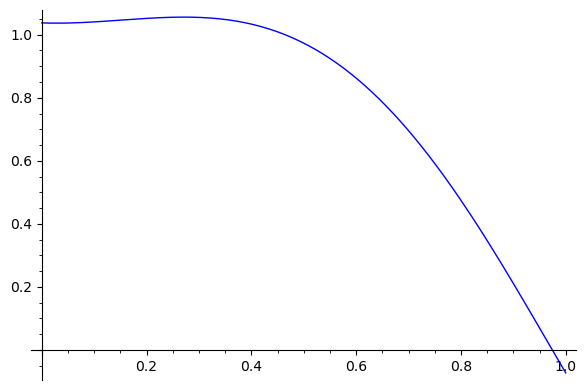

In [29]:
plot(1.62581436*t^5 - 1.75868575*t^4 - 2.02667306*t^3 + 1.10663055*t^2 - 0.05701294*t + 1.03739201,0,1)

Huh. It doesn't have the usual hump. Let's keep running the amoeba.

In [21]:
amoeba(f = temp_loss_function, n = 6, initial_point=array([ 1.03739201, -0.05701294,  1.10663055, -2.02667306, -1.75868575,
        1.62581436]),  initial_step = 0.01 )

Independent variables at current minimum: array([ 1.03739201, -0.05701294,  1.10663055, -2.02667306, -1.75868575,
        1.62581436])
Dependent variable at current minimum: 0.0131428562351774
Standard deviation of dependent variables of all 7 vertices: 0.0000251753431460442
Function evaluations: 8
Independent variables at current minimum: array([ 1.04405868, -0.05034627,  1.11329722, -2.02000639, -1.77701908,
        1.62081436])
Dependent variable at current minimum: 0.0131077143382553
Standard deviation of dependent variables of all 7 vertices: 0.0000314534855836091
Function evaluations: 10
Independent variables at current minimum: array([ 1.04405868, -0.05034627,  1.11329722, -2.02000639, -1.77701908,
        1.62081436])
Dependent variable at current minimum: 0.0131077143382553
Standard deviation of dependent variables of all 7 vertices: 0.0000310168292252195
Function evaluations: 11
Independent variables at current minimum: array([ 1.05072534, -0.04367961,  1.09496388, -2.0250063

Independent variables at current minimum: array([ 1.06404357, -0.03322312,  1.08729444, -2.01815077, -1.81651627,
        1.60926643])
Dependent variable at current minimum: 0.0127953747316337
Standard deviation of dependent variables of all 7 vertices: 9.73765735804060e-6
Function evaluations: 56
Independent variables at current minimum: array([ 1.06404357, -0.03322312,  1.08729444, -2.01815077, -1.81651627,
        1.60926643])
Dependent variable at current minimum: 0.0127953747316337
Standard deviation of dependent variables of all 7 vertices: 8.76755799736232e-6
Function evaluations: 58
Independent variables at current minimum: array([ 1.06404357, -0.03322312,  1.08729444, -2.01815077, -1.81651627,
        1.60926643])
Dependent variable at current minimum: 0.0127953747316337
Standard deviation of dependent variables of all 7 vertices: 8.26303546466323e-6
Function evaluations: 59
Independent variables at current minimum: array([ 1.05962496, -0.02781139,  1.07808218, -2.01274663, -1

Independent variables at current minimum: array([ 1.05545048, -0.02345649,  1.07966837, -2.01317313, -1.81350759,
        1.59968976])
Dependent variable at current minimum: 0.0127620695653260
Standard deviation of dependent variables of all 7 vertices: 1.51921849891202e-6
Function evaluations: 105
Independent variables at current minimum: array([ 1.05545048, -0.02345649,  1.07966837, -2.01317313, -1.81350759,
        1.59968976])
Dependent variable at current minimum: 0.0127620695653260
Standard deviation of dependent variables of all 7 vertices: 1.37528781955517e-6
Function evaluations: 107
Independent variables at current minimum: array([ 1.05591216, -0.02431613,  1.0827898 , -2.01752563, -1.81337386,
        1.60152022])
Dependent variable at current minimum: 0.0127616325760097
Standard deviation of dependent variables of all 7 vertices: 1.57322430695862e-6
Function evaluations: 109
Independent variables at current minimum: array([ 1.05591216, -0.02431613,  1.0827898 , -2.01752563,

Independent variables at current minimum: array([ 1.0559316 , -0.01881987,  1.06119966, -2.00595807, -1.8047409 ,
        1.59534916])
Dependent variable at current minimum: 0.0127590395803905
Standard deviation of dependent variables of all 7 vertices: 3.59214254742724e-7
Function evaluations: 156
Independent variables at current minimum: array([ 1.05517937, -0.01611105,  1.05200496, -1.99778461, -1.8029592 ,
        1.5915811 ])
Dependent variable at current minimum: 0.0127582754241314
Standard deviation of dependent variables of all 7 vertices: 5.44380782384712e-7
Function evaluations: 158
Independent variables at current minimum: array([ 1.05517937, -0.01611105,  1.05200496, -1.99778461, -1.8029592 ,
        1.5915811 ])
Dependent variable at current minimum: 0.0127582754241314
Standard deviation of dependent variables of all 7 vertices: 5.26606900201064e-7
Function evaluations: 159
Independent variables at current minimum: array([ 1.05517937, -0.01611105,  1.05200496, -1.99778461,

Independent variables at current minimum: array([ 1.03969365,  0.06950796,  0.74636831, -1.76762124, -1.71978461,
        1.48085574])
Dependent variable at current minimum: 0.0127391222309525
Standard deviation of dependent variables of all 7 vertices: 3.50202940667817e-6
Function evaluations: 194
Independent variables at current minimum: array([ 1.03969365,  0.06950796,  0.74636831, -1.76762124, -1.71978461,
        1.48085574])
Dependent variable at current minimum: 0.0127391222309525
Standard deviation of dependent variables of all 7 vertices: 3.52167860134479e-6
Function evaluations: 195
Independent variables at current minimum: array([ 1.03969365,  0.06950796,  0.74636831, -1.76762124, -1.71978461,
        1.48085574])
Dependent variable at current minimum: 0.0127391222309525
Standard deviation of dependent variables of all 7 vertices: 3.06668690490512e-6
Function evaluations: 196
Independent variables at current minimum: array([ 1.03148438,  0.10587413,  0.62748518, -1.67897805,

Independent variables at current minimum: array([ 1.00789872,  0.20283839,  0.30743851, -1.42401319, -1.61469267,
        1.31751125])
Dependent variable at current minimum: 0.0126795134115889
Standard deviation of dependent variables of all 7 vertices: 1.55765633813213e-6
Function evaluations: 238
Independent variables at current minimum: array([ 1.00791672,  0.2002181 ,  0.31867044, -1.43159481, -1.61854339,
        1.32125582])
Dependent variable at current minimum: 0.0126775846769671
Standard deviation of dependent variables of all 7 vertices: 2.04682255766267e-6
Function evaluations: 240
Independent variables at current minimum: array([ 1.00791672,  0.2002181 ,  0.31867044, -1.43159481, -1.61854339,
        1.32125582])
Dependent variable at current minimum: 0.0126775846769671
Standard deviation of dependent variables of all 7 vertices: 1.95417369925963e-6
Function evaluations: 242
Independent variables at current minimum: array([ 1.00792152,  0.19328555,  0.34833258, -1.45059518,

Independent variables at current minimum: array([ 1.01136622,  0.12681781,  0.6278857 , -1.64993701, -1.7195054 ,
        1.42820325])
Dependent variable at current minimum: 0.0126511493814793
Standard deviation of dependent variables of all 7 vertices: 5.43880035964743e-7
Function evaluations: 280
Independent variables at current minimum: array([ 1.01136622,  0.12681781,  0.6278857 , -1.64993701, -1.7195054 ,
        1.42820325])
Dependent variable at current minimum: 0.0126511493814793
Standard deviation of dependent variables of all 7 vertices: 4.70464275070808e-7
Function evaluations: 282
Independent variables at current minimum: array([ 1.01118234,  0.12190631,  0.65034709, -1.66510688, -1.72747459,
        1.4357179 ])
Dependent variable at current minimum: 0.0126510908916068
Standard deviation of dependent variables of all 7 vertices: 3.35823892743287e-7
Function evaluations: 284
Independent variables at current minimum: array([ 1.01086646,  0.12012729,  0.66134315, -1.67440933,

Independent variables at current minimum: array([ 1.01070493,  0.11869784,  0.68042025, -1.70313986, -1.73144608,
        1.4519194 ])
Dependent variable at current minimum: 0.0126457856801824
Standard deviation of dependent variables of all 7 vertices: 1.15243228311590e-6
Function evaluations: 324
Independent variables at current minimum: array([ 1.01070493,  0.11869784,  0.68042025, -1.70313986, -1.73144608,
        1.4519194 ])
Dependent variable at current minimum: 0.0126457856801824
Standard deviation of dependent variables of all 7 vertices: 1.00351217469186e-6
Function evaluations: 325
Independent variables at current minimum: array([ 1.01040591,  0.12242801,  0.67022276, -1.70208086, -1.72590176,
        1.45051767])
Dependent variable at current minimum: 0.0126431530290273
Standard deviation of dependent variables of all 7 vertices: 1.68588237552051e-6
Function evaluations: 327
Independent variables at current minimum: array([ 1.01040591,  0.12242801,  0.67022276, -1.70208086,

Independent variables at current minimum: array([ 1.00678626,  0.13464816,  0.76960791, -1.94589302, -1.69443286,
        1.54483018])
Dependent variable at current minimum: 0.0125838328327297
Standard deviation of dependent variables of all 7 vertices: 0.0000104021554000810
Function evaluations: 365
Independent variables at current minimum: array([ 1.00678626,  0.13464816,  0.76960791, -1.94589302, -1.69443286,
        1.54483018])
Dependent variable at current minimum: 0.0125838328327297
Standard deviation of dependent variables of all 7 vertices: 9.27671007382642e-6
Function evaluations: 366
Independent variables at current minimum: array([ 1.00678626,  0.13464816,  0.76960791, -1.94589302, -1.69443286,
        1.54483018])
Dependent variable at current minimum: 0.0125838328327297
Standard deviation of dependent variables of all 7 vertices: 8.33477076527465e-6
Function evaluations: 367
Independent variables at current minimum: array([ 1.00522396,  0.15100346,  0.73204238, -1.9540457

Independent variables at current minimum: array([ 1.00511381,  0.16491702,  0.68115581, -1.93248707, -1.64688677,
        1.53115273])
Dependent variable at current minimum: 0.0125664091806197
Standard deviation of dependent variables of all 7 vertices: 1.36913543253171e-6
Function evaluations: 411
Independent variables at current minimum: array([ 1.00511381,  0.16491702,  0.68115581, -1.93248707, -1.64688677,
        1.53115273])
Dependent variable at current minimum: 0.0125664091806197
Standard deviation of dependent variables of all 7 vertices: 1.27580621282976e-6
Function evaluations: 413
Independent variables at current minimum: array([ 1.00511381,  0.16491702,  0.68115581, -1.93248707, -1.64688677,
        1.53115273])
Dependent variable at current minimum: 0.0125664091806197
Standard deviation of dependent variables of all 7 vertices: 1.25110672293190e-6
Function evaluations: 414
Independent variables at current minimum: array([ 1.00511381,  0.16491702,  0.68115581, -1.93248707,

Independent variables at current minimum: array([ 1.00485777,  0.17056867,  0.66039503, -1.92185975, -1.63854875,
        1.52536448])
Dependent variable at current minimum: 0.0125660255167774
Standard deviation of dependent variables of all 7 vertices: 1.67611435587194e-7
Function evaluations: 461
Independent variables at current minimum: array([ 1.00485777,  0.17056867,  0.66039503, -1.92185975, -1.63854875,
        1.52536448])
Dependent variable at current minimum: 0.0125660255167774
Standard deviation of dependent variables of all 7 vertices: 1.55277718997552e-7
Function evaluations: 463
Independent variables at current minimum: array([ 1.00485777,  0.17056867,  0.66039503, -1.92185975, -1.63854875,
        1.52536448])
Dependent variable at current minimum: 0.0125660255167774
Standard deviation of dependent variables of all 7 vertices: 1.47445897848861e-7
Function evaluations: 464
Independent variables at current minimum: array([ 1.00485777,  0.17056867,  0.66039503, -1.92185975,

Independent variables at current minimum: array([ 1.00486728,  0.17080805,  0.65935838, -1.92125173, -1.63814115,
        1.52504856])
Dependent variable at current minimum: 0.0125659851065600
Standard deviation of dependent variables of all 7 vertices: 2.49254293970473e-8
Function evaluations: 512
Independent variables at current minimum: array([ 1.00486728,  0.17080805,  0.65935838, -1.92125173, -1.63814115,
        1.52504856])
Dependent variable at current minimum: 0.0125659851065600
Standard deviation of dependent variables of all 7 vertices: 2.35855666489232e-8
Function evaluations: 514
Independent variables at current minimum: array([ 1.00486728,  0.17080805,  0.65935838, -1.92125173, -1.63814115,
        1.52504856])
Dependent variable at current minimum: 0.0125659851065600
Standard deviation of dependent variables of all 7 vertices: 2.24825432666219e-8
Function evaluations: 515
Independent variables at current minimum: array([ 1.00486728,  0.17080805,  0.65935838, -1.92125173,

Independent variables at current minimum: array([ 1.00486937,  0.17136098,  0.65711126, -1.91998819, -1.63725445,
        1.52438287])
Dependent variable at current minimum: 0.0125659659979392
Standard deviation of dependent variables of all 7 vertices: 4.93214283327207e-9
Function evaluations: 560
Independent variables at current minimum: array([ 1.00486937,  0.17136098,  0.65711126, -1.91998819, -1.63725445,
        1.52438287])
Dependent variable at current minimum: 0.0125659659979392
Standard deviation of dependent variables of all 7 vertices: 4.60560212524642e-9
Function evaluations: 562
Independent variables at current minimum: array([ 1.00486937,  0.17136098,  0.65711126, -1.91998819, -1.63725445,
        1.52438287])
Dependent variable at current minimum: 0.0125659659979392
Standard deviation of dependent variables of all 7 vertices: 4.41969655373049e-9
Function evaluations: 563
Independent variables at current minimum: array([ 1.00486937,  0.17136098,  0.65711126, -1.91998819,

Independent variables at current minimum: array([ 1.00485772,  0.17177921,  0.65551371, -1.91913516, -1.63661896,
        1.5239253 ])
Dependent variable at current minimum: 0.0125659569091793
Standard deviation of dependent variables of all 7 vertices: 1.17159058670558e-9
Function evaluations: 609
Independent variables at current minimum: array([ 1.00485273,  0.17199651,  0.65467531, -1.91868344, -1.63628595,
        1.52368376])
Dependent variable at current minimum: 0.0125659566617909
Standard deviation of dependent variables of all 7 vertices: 1.30427318352865e-9
Function evaluations: 611
Independent variables at current minimum: array([ 1.00485273,  0.17199651,  0.65467531, -1.91868344, -1.63628595,
        1.52368376])
Dependent variable at current minimum: 0.0125659566617909
Standard deviation of dependent variables of all 7 vertices: 1.20793539436825e-9
Function evaluations: 613
Independent variables at current minimum: array([ 1.00485273,  0.17199651,  0.65467531, -1.91868344,

In [22]:
amoeba(f = temp_loss_function, n = 6, initial_point=array([ 1.00485273,  0.17199651,  0.65467531, -1.91868344, -1.63628595,
        1.52368376]),  initial_step = 0.01 )

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f969603a8c0>)
Independent variables at current minimum: array([ 1.00485273,  0.17199651,  0.66467531, -1.91868344, -1.63628595,
        1.52368376])
Dependent variable at current minimum: 0.0126027596279033
Standard deviation of dependent variables of all 7 vertices: 225.826103142100
Function evaluations: 9
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f9695ad73c0>)
Independent variables at current minimum: array([ 1.00485273,  0.17199651,  0.66467531, -1.91868344, -1.63628595,
        1.52368376])
Dependent variable at current minimum: 0.0126027596279033
Standard deviation of dependent variables of all 7 verti

Independent variables at current minimum: array([ 1.00430574,  0.1778113 ,  0.64926325, -1.91380486, -1.63247111,
        1.51769936])
Dependent variable at current minimum: 0.0125710891598761
Standard deviation of dependent variables of all 7 vertices: 2.35891392556039e-6
Function evaluations: 55
Independent variables at current minimum: array([ 1.00451266,  0.17487326,  0.65187551, -1.91468951, -1.63286508,
        1.51820221])
Dependent variable at current minimum: 0.0125701706703532
Standard deviation of dependent variables of all 7 vertices: 2.64830681388753e-6
Function evaluations: 57
Independent variables at current minimum: array([ 1.00451266,  0.17487326,  0.65187551, -1.91468951, -1.63286508,
        1.51820221])
Dependent variable at current minimum: 0.0125701706703532
Standard deviation of dependent variables of all 7 vertices: 2.44057975484678e-6
Function evaluations: 58
Independent variables at current minimum: array([ 1.00451266,  0.17487326,  0.65187551, -1.91468951, -1

Independent variables at current minimum: array([ 1.00551277,  0.16951166,  0.63905711, -1.92168197, -1.63884131,
        1.53854507])
Dependent variable at current minimum: 0.0125619807053584
Standard deviation of dependent variables of all 7 vertices: 7.38876636357088e-7
Function evaluations: 104
Independent variables at current minimum: array([ 1.00551277,  0.16951166,  0.63905711, -1.92168197, -1.63884131,
        1.53854507])
Dependent variable at current minimum: 0.0125619807053584
Standard deviation of dependent variables of all 7 vertices: 6.58673893803263e-7
Function evaluations: 105
Independent variables at current minimum: array([ 1.00551277,  0.16951166,  0.63905711, -1.92168197, -1.63884131,
        1.53854507])
Dependent variable at current minimum: 0.0125619807053584
Standard deviation of dependent variables of all 7 vertices: 5.40526552188081e-7
Function evaluations: 107
Independent variables at current minimum: array([ 1.00551277,  0.16951166,  0.63905711, -1.92168197,

Independent variables at current minimum: array([ 1.00530564,  0.17063493,  0.64036076, -1.92324383, -1.6397675 ,
        1.53941056])
Dependent variable at current minimum: 0.0125611729244305
Standard deviation of dependent variables of all 7 vertices: 1.02030982422470e-7
Function evaluations: 148
Independent variables at current minimum: array([ 1.00545383,  0.16988689,  0.6398843 , -1.92396165, -1.64029272,
        1.54103623])
Dependent variable at current minimum: 0.0125610008736627
Standard deviation of dependent variables of all 7 vertices: 1.40408778687231e-7
Function evaluations: 150
Independent variables at current minimum: array([ 1.00545383,  0.16988689,  0.6398843 , -1.92396165, -1.64029272,
        1.54103623])
Dependent variable at current minimum: 0.0125610008736627
Standard deviation of dependent variables of all 7 vertices: 1.24633821163552e-7
Function evaluations: 152
Independent variables at current minimum: array([ 1.00545383,  0.16988689,  0.6398843 , -1.92396165,

Independent variables at current minimum: array([ 1.00389067,  0.18527184,  0.62945474, -1.93917959, -1.65220374,
        1.56505096])
Dependent variable at current minimum: 0.0125573949635796
Standard deviation of dependent variables of all 7 vertices: 7.08921041856216e-7
Function evaluations: 193
Independent variables at current minimum: array([ 1.00374432,  0.18689914,  0.62365165, -1.94360124, -1.65594569,
        1.57487549])
Dependent variable at current minimum: 0.0125562635400987
Standard deviation of dependent variables of all 7 vertices: 9.28170909566019e-7
Function evaluations: 195
Independent variables at current minimum: array([ 1.00374432,  0.18689914,  0.62365165, -1.94360124, -1.65594569,
        1.57487549])
Dependent variable at current minimum: 0.0125562635400987
Standard deviation of dependent variables of all 7 vertices: 7.88226922155192e-7
Function evaluations: 196
Independent variables at current minimum: array([ 1.00367645,  0.18766888,  0.62429993, -1.94391446,

Independent variables at current minimum: array([ 1.00260021,  0.20310217,  0.61436222, -1.96164283, -1.66960424,
        1.60211948])
Dependent variable at current minimum: 0.0125528705859556
Standard deviation of dependent variables of all 7 vertices: 5.25374909436375e-7
Function evaluations: 237
Independent variables at current minimum: array([ 1.00260021,  0.20310217,  0.61436222, -1.96164283, -1.66960424,
        1.60211948])
Dependent variable at current minimum: 0.0125528705859556
Standard deviation of dependent variables of all 7 vertices: 4.74622594099269e-7
Function evaluations: 238
Independent variables at current minimum: array([ 1.00282562,  0.20165919,  0.61536083, -1.9607431 , -1.6688288 ,
        1.60063552])
Dependent variable at current minimum: 0.0125522023457040
Standard deviation of dependent variables of all 7 vertices: 6.56212155587979e-7
Function evaluations: 240
Independent variables at current minimum: array([ 1.00282562,  0.20165919,  0.61536083, -1.9607431 ,

Independent variables at current minimum: array([ 1.00132826,  0.23021382,  0.59503658, -1.99765571, -1.69682009,
        1.65896572])
Dependent variable at current minimum: 0.0125479118305147
Standard deviation of dependent variables of all 7 vertices: 4.32175606305536e-7
Function evaluations: 281
Independent variables at current minimum: array([ 1.00132826,  0.23021382,  0.59503658, -1.99765571, -1.69682009,
        1.65896572])
Dependent variable at current minimum: 0.0125479118305147
Standard deviation of dependent variables of all 7 vertices: 4.11405209144914e-7
Function evaluations: 282
Independent variables at current minimum: array([ 1.00132826,  0.23021382,  0.59503658, -1.99765571, -1.69682009,
        1.65896572])
Dependent variable at current minimum: 0.0125479118305147
Standard deviation of dependent variables of all 7 vertices: 3.50633888180005e-7
Function evaluations: 284
Independent variables at current minimum: array([ 1.00132826,  0.23021382,  0.59503658, -1.99765571,

Independent variables at current minimum: array([ 1.00106706,  0.2361498 ,  0.59124483, -2.00574922, -1.70286638,
        1.67141062])
Dependent variable at current minimum: 0.0125473411401823
Standard deviation of dependent variables of all 7 vertices: 6.67843256267618e-8
Function evaluations: 327
Independent variables at current minimum: array([ 1.00095188,  0.23849914,  0.58987238, -2.00889098, -1.70520142,
        1.67615044])
Dependent variable at current minimum: 0.0125472336732762
Standard deviation of dependent variables of all 7 vertices: 9.30259588716222e-8
Function evaluations: 329
Independent variables at current minimum: array([ 1.00095188,  0.23849914,  0.58987238, -2.00889098, -1.70520142,
        1.67615044])
Dependent variable at current minimum: 0.0125472336732762
Standard deviation of dependent variables of all 7 vertices: 8.43512951776725e-8
Function evaluations: 330
Independent variables at current minimum: array([ 1.00093652,  0.23856941,  0.58965462, -2.0088259 ,

Independent variables at current minimum: array([ 1.00072461,  0.24475859,  0.58578245, -2.01741822, -1.71158062,
        1.68935649])
Dependent variable at current minimum: 0.0125469565173006
Standard deviation of dependent variables of all 7 vertices: 1.83055275139264e-8
Function evaluations: 376
Independent variables at current minimum: array([ 1.00072461,  0.24475859,  0.58578245, -2.01741822, -1.71158062,
        1.68935649])
Dependent variable at current minimum: 0.0125469565173006
Standard deviation of dependent variables of all 7 vertices: 1.75415975101223e-8
Function evaluations: 377
Independent variables at current minimum: array([ 1.00072461,  0.24475859,  0.58578245, -2.01741822, -1.71158062,
        1.68935649])
Dependent variable at current minimum: 0.0125469565173006
Standard deviation of dependent variables of all 7 vertices: 1.73611993600550e-8
Function evaluations: 378
Independent variables at current minimum: array([ 1.00072461,  0.24475859,  0.58578245, -2.01741822,

Independent variables at current minimum: array([ 1.00068906,  0.24597131,  0.58512715, -2.01922011, -1.7129004 ,
        1.69203551])
Dependent variable at current minimum: 0.0125469287144000
Standard deviation of dependent variables of all 7 vertices: 5.27754250552386e-9
Function evaluations: 421
Independent variables at current minimum: array([ 1.0006733 ,  0.24636981,  0.58485157, -2.01973795, -1.71329155,
        1.6928508 ])
Dependent variable at current minimum: 0.0125469270374324
Standard deviation of dependent variables of all 7 vertices: 5.20010707859413e-9
Function evaluations: 423
Independent variables at current minimum: array([ 1.0006733 ,  0.24636981,  0.58485157, -2.01973795, -1.71329155,
        1.6928508 ])
Dependent variable at current minimum: 0.0125469270374324
Standard deviation of dependent variables of all 7 vertices: 4.57670159111655e-9
Function evaluations: 425
Independent variables at current minimum: array([ 1.0006733 ,  0.24636981,  0.58485157, -2.01973795,

In [24]:
plot_quintic( array([ 1.00067726,  0.24634013,  0.58490898, -2.01974627, -1.71328943,
        1.69283212]) ,my_training_maybe_inverse_slopes = 
                                    ( 0.25, 0.5, 0.75, 1),
          show_3d = True, high = 1)

t |--> 1.69283212*t^5 - 1.71328943*t^4 - 2.01974627*t^3 + 0.58490898*t^2 + 0.24634013*t + 1.00067726
0.176675490031431
0.194358649839268
0.207395539195997
0.200058522375734

Deviation of training angles: 0.0125554273302209


0.185719059756795
0.202028439029209
0.206425225625086

Deviation of testing angles: 0.00911671255549355


Graphics3d Object

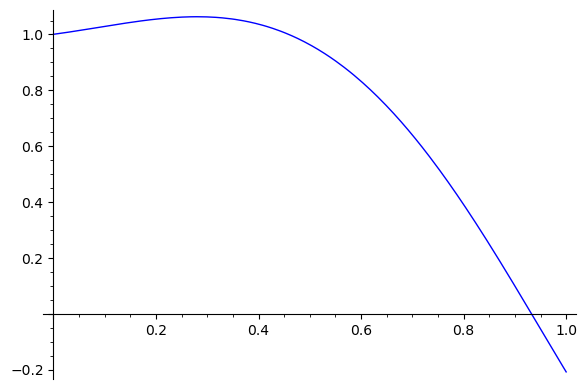

In [30]:
plot(1.69283212*t^5 - 1.71328943*t^4 - 2.01974627*t^3 + 0.58490898*t^2 + 0.24634013*t + 1.00067726,0,1)

Now there is a slight hump. I'm wary of interpreting the coefficients as a Taylor series,
since (for instance) the linear coefficient has changed sign compared to the intermediate step above.

What if we optimize on more points along that meridian?

In [25]:
temp_loss_function = get_loss_function_quintic(maybe_inverse_slopes = ( 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1),
    goal = 0.20,
    meridian = tau/6,
    low = 0,
    high = 100 )
amoeba(f = temp_loss_function, n = 6, initial_point=array([ 1.00067726,  0.24634013,  0.58490898, -2.01974627, -1.71328943,
        1.69283212]),  initial_step = 0.01 )

(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96977f6680>)
Independent variables at current minimum: array([ 1.00067726,  0.24634013,  0.58490898, -2.01974627, -1.71328943,
        1.69283212])
Dependent variable at current minimum: 0.0112076660245282
Standard deviation of dependent variables of all 7 vertices: 0.000133948979453342
Function evaluations: 9
(<class 'TypeError'>, TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''"), <traceback object at 0x7f96977fa180>)
Independent variables at current minimum: array([ 1.00067726,  0.24634013,  0.58490898, -2.01974627, -1.71328943,
        1.69283212])
Dependent variable at current minimum: 0.0112076660245282
Standard deviation of dependent variables of all 7 v

Independent variables at current minimum: array([ 1.00042455,  0.25299854,  0.5893257 , -2.02288564, -1.71279163,
        1.6899016 ])
Dependent variable at current minimum: 0.0111941612400391
Standard deviation of dependent variables of all 7 vertices: 2.95659325936093e-6
Function evaluations: 53
Independent variables at current minimum: array([ 1.00042455,  0.25299854,  0.5893257 , -2.02288564, -1.71279163,
        1.6899016 ])
Dependent variable at current minimum: 0.0111941612400391
Standard deviation of dependent variables of all 7 vertices: 2.22962367638933e-6
Function evaluations: 55
Independent variables at current minimum: array([ 1.00042455,  0.25299854,  0.5893257 , -2.02288564, -1.71279163,
        1.6899016 ])
Dependent variable at current minimum: 0.0111941612400391
Standard deviation of dependent variables of all 7 vertices: 2.18133095959365e-6
Function evaluations: 56
Independent variables at current minimum: array([ 1.00023783,  0.26002718,  0.59448515, -2.01738535, -1

Independent variables at current minimum: array([ 1.00029663,  0.25827053,  0.59636186, -2.02360099, -1.70991982,
        1.68136666])
Dependent variable at current minimum: 0.0111831769142319
Standard deviation of dependent variables of all 7 vertices: 9.37768449289024e-7
Function evaluations: 101
Independent variables at current minimum: array([ 1.00029663,  0.25827053,  0.59636186, -2.02360099, -1.70991982,
        1.68136666])
Dependent variable at current minimum: 0.0111831769142319
Standard deviation of dependent variables of all 7 vertices: 9.90885632283871e-7
Function evaluations: 102
Independent variables at current minimum: array([ 1.00029663,  0.25827053,  0.59636186, -2.02360099, -1.70991982,
        1.68136666])
Dependent variable at current minimum: 0.0111831769142319
Standard deviation of dependent variables of all 7 vertices: 8.87239201594166e-7
Function evaluations: 103
Independent variables at current minimum: array([ 1.00029663,  0.25827053,  0.59636186, -2.02360099,

Independent variables at current minimum: array([ 1.0002015 ,  0.26133635,  0.60440244, -2.03171163, -1.70733353,
        1.67944767])
Dependent variable at current minimum: 0.0111795288163262
Standard deviation of dependent variables of all 7 vertices: 4.86052693836748e-7
Function evaluations: 145
Independent variables at current minimum: array([ 1.00015176,  0.26296767,  0.60762016, -2.03457067, -1.70625258,
        1.67825397])
Dependent variable at current minimum: 0.0111794896650862
Standard deviation of dependent variables of all 7 vertices: 4.17053431267928e-7
Function evaluations: 147
Independent variables at current minimum: array([ 1.00016365,  0.26371396,  0.61241423, -2.03912833, -1.70396223,
        1.67668553])
Dependent variable at current minimum: 0.0111792956632514
Standard deviation of dependent variables of all 7 vertices: 3.88970946207986e-7
Function evaluations: 149
Independent variables at current minimum: array([ 1.0001643 ,  0.26349878,  0.61640194, -2.04406522,

Independent variables at current minimum: array([ 1.00016316,  0.26384044,  0.62021167, -2.04912793, -1.701491  ,
        1.67738898])
Dependent variable at current minimum: 0.0111770757300521
Standard deviation of dependent variables of all 7 vertices: 1.19320005697814e-7
Function evaluations: 191
Independent variables at current minimum: array([ 1.00016316,  0.26384044,  0.62021167, -2.04912793, -1.701491  ,
        1.67738898])
Dependent variable at current minimum: 0.0111770757300521
Standard deviation of dependent variables of all 7 vertices: 1.31339170800139e-7
Function evaluations: 192
Independent variables at current minimum: array([ 1.00016316,  0.26384044,  0.62021167, -2.04912793, -1.701491  ,
        1.67738898])
Dependent variable at current minimum: 0.0111770757300521
Standard deviation of dependent variables of all 7 vertices: 1.27618782352749e-7
Function evaluations: 193
Independent variables at current minimum: array([ 1.00016316,  0.26384044,  0.62021167, -2.04912793,

Independent variables at current minimum: array([ 1.00023768,  0.25451114,  0.67266357, -2.1145975 , -1.68606344,
        1.68704444])
Dependent variable at current minimum: 0.0111693333104448
Standard deviation of dependent variables of all 7 vertices: 1.48175022024563e-6
Function evaluations: 230
Independent variables at current minimum: array([ 1.00027709,  0.25145545,  0.69258117, -2.13912196, -1.67983228,
        1.68986631])
Dependent variable at current minimum: 0.0111674022255791
Standard deviation of dependent variables of all 7 vertices: 1.78468543105946e-6
Function evaluations: 232
Independent variables at current minimum: array([ 1.00027709,  0.25145545,  0.69258117, -2.13912196, -1.67983228,
        1.68986631])
Dependent variable at current minimum: 0.0111674022255791
Standard deviation of dependent variables of all 7 vertices: 1.78733672653540e-6
Function evaluations: 233
Independent variables at current minimum: array([ 1.00031949,  0.24663343,  0.70603278, -2.1570689 ,

Independent variables at current minimum: array([ 1.00186304,  0.15184706,  1.12418805, -2.69091973, -1.54843929,
        1.78306618])
Dependent variable at current minimum: 0.0111105959930633
Standard deviation of dependent variables of all 7 vertices: 3.81677218507659e-6
Function evaluations: 274
Independent variables at current minimum: array([ 1.0021427 ,  0.14348524,  1.13606727, -2.70962184, -1.54383983,
        1.7893535 ])
Dependent variable at current minimum: 0.0111032617239535
Standard deviation of dependent variables of all 7 vertices: 5.27893190566917e-6
Function evaluations: 276
Independent variables at current minimum: array([ 1.0021427 ,  0.14348524,  1.13606727, -2.70962184, -1.54383983,
        1.7893535 ])
Dependent variable at current minimum: 0.0111032617239535
Standard deviation of dependent variables of all 7 vertices: 5.60264749502667e-6
Function evaluations: 277
Independent variables at current minimum: array([ 1.0021427 ,  0.14348524,  1.13606727, -2.70962184,

Independent variables at current minimum: array([ 1.00479107,  0.06868557,  1.44690452, -3.11386955, -1.42984656,
        1.84296833])
Dependent variable at current minimum: 0.0110490980957141
Standard deviation of dependent variables of all 7 vertices: 5.31932744347280e-6
Function evaluations: 318
Independent variables at current minimum: array([ 1.00479107,  0.06868557,  1.44690452, -3.11386955, -1.42984656,
        1.84296833])
Dependent variable at current minimum: 0.0110490980957141
Standard deviation of dependent variables of all 7 vertices: 4.82925050333220e-6
Function evaluations: 319
Independent variables at current minimum: array([ 1.00479107,  0.06868557,  1.44690452, -3.11386955, -1.42984656,
        1.84296833])
Dependent variable at current minimum: 0.0110490980957141
Standard deviation of dependent variables of all 7 vertices: 4.05682960729289e-6
Function evaluations: 320
Independent variables at current minimum: array([ 1.00594101,  0.03015963,  1.63041308, -3.3481361 ,

Independent variables at current minimum: array([ 1.00710943,  0.00415461,  1.75561837, -3.50933116, -1.3169401 ,
        1.88838975])
Dependent variable at current minimum: 0.0110322950289772
Standard deviation of dependent variables of all 7 vertices: 8.16226268912597e-7
Function evaluations: 362
Independent variables at current minimum: array([ 1.00783621, -0.0140385 ,  1.84621854, -3.62565338, -1.28295609,
        1.9008178 ])
Dependent variable at current minimum: 0.0110322000730950
Standard deviation of dependent variables of all 7 vertices: 6.98456720896088e-7
Function evaluations: 364
Independent variables at current minimum: array([ 1.00783621, -0.0140385 ,  1.84621854, -3.62565338, -1.28295609,
        1.9008178 ])
Dependent variable at current minimum: 0.0110322000730950
Standard deviation of dependent variables of all 7 vertices: 5.81889088922806e-7
Function evaluations: 366
Independent variables at current minimum: array([ 1.00689054,  0.01137569,  1.72486431, -3.469828  ,

Independent variables at current minimum: array([ 1.00764764, -0.00909208,  1.81884765, -3.59173324, -1.29317079,
        1.89822077])
Dependent variable at current minimum: 0.0110296659011408
Standard deviation of dependent variables of all 7 vertices: 2.94376008140726e-7
Function evaluations: 409
Independent variables at current minimum: array([ 1.00764764, -0.00909208,  1.81884765, -3.59173324, -1.29317079,
        1.89822077])
Dependent variable at current minimum: 0.0110296659011408
Standard deviation of dependent variables of all 7 vertices: 2.62468707269836e-7
Function evaluations: 410
Independent variables at current minimum: array([ 1.00764764, -0.00909208,  1.81884765, -3.59173324, -1.29317079,
        1.89822077])
Dependent variable at current minimum: 0.0110296659011408
Standard deviation of dependent variables of all 7 vertices: 2.19832592313481e-7
Function evaluations: 411
Independent variables at current minimum: array([ 1.00764764, -0.00909208,  1.81884765, -3.59173324,

Independent variables at current minimum: array([ 1.00849894, -0.02963313,  1.90698492, -3.71833675, -1.26136453,
        1.92390535])
Dependent variable at current minimum: 0.0110157788140740
Standard deviation of dependent variables of all 7 vertices: 2.68686028879066e-6
Function evaluations: 447
Independent variables at current minimum: array([ 1.00849894, -0.02963313,  1.90698492, -3.71833675, -1.26136453,
        1.92390535])
Dependent variable at current minimum: 0.0110157788140740
Standard deviation of dependent variables of all 7 vertices: 2.75088121305457e-6
Function evaluations: 448
Independent variables at current minimum: array([ 1.00860864, -0.02894586,  1.90838392, -3.72440975, -1.25990082,
        1.92642878])
Dependent variable at current minimum: 0.0110098671612696
Standard deviation of dependent variables of all 7 vertices: 3.77818239352326e-6
Function evaluations: 450
Independent variables at current minimum: array([ 1.00860864, -0.02894586,  1.90838392, -3.72440975,

Independent variables at current minimum: array([ 1.02124125, -0.29972916,  3.17789348, -5.5265407 , -0.78475865,
        2.25241491])
Dependent variable at current minimum: 0.0108962713665405
Standard deviation of dependent variables of all 7 vertices: 0.0000166293905382557
Function evaluations: 491
Independent variables at current minimum: array([ 1.02124125, -0.29972916,  3.17789348, -5.5265407 , -0.78475865,
        2.25241491])
Dependent variable at current minimum: 0.0108962713665405
Standard deviation of dependent variables of all 7 vertices: 0.0000144292524120258
Function evaluations: 492
Independent variables at current minimum: array([ 1.0249569 , -0.375504  ,  3.54204838, -6.04655364, -0.64711071,
        2.34651202])
Dependent variable at current minimum: 0.0108843667454751
Standard deviation of dependent variables of all 7 vertices: 0.0000157761015457109
Function evaluations: 494
Independent variables at current minimum: array([ 1.0249569 , -0.375504  ,  3.54204838, -6.046

Independent variables at current minimum: array([ 1.0272194 , -0.41260794,  3.73629855, -6.33481619, -0.57060227,
        2.40162103])
Dependent variable at current minimum: 0.0108724077622080
Standard deviation of dependent variables of all 7 vertices: 7.85344394239371e-7
Function evaluations: 539
Independent variables at current minimum: array([ 1.0272194 , -0.41260794,  3.73629855, -6.33481619, -0.57060227,
        2.40162103])
Dependent variable at current minimum: 0.0108724077622080
Standard deviation of dependent variables of all 7 vertices: 6.45618109372888e-7
Function evaluations: 541
Independent variables at current minimum: array([ 1.0272194 , -0.41260794,  3.73629855, -6.33481619, -0.57060227,
        2.40162103])
Dependent variable at current minimum: 0.0108724077622080
Standard deviation of dependent variables of all 7 vertices: 5.92751153841026e-7
Function evaluations: 542
Independent variables at current minimum: array([ 1.0272194 , -0.41260794,  3.73629855, -6.33481619,

Independent variables at current minimum: array([ 1.02878858, -0.44319555,  3.8858643 , -6.55026867, -0.51362232,
        2.44121806])
Dependent variable at current minimum: 0.0108711905012794
Standard deviation of dependent variables of all 7 vertices: 1.19676843053547e-7
Function evaluations: 585
Independent variables at current minimum: array([ 1.02878858, -0.44319555,  3.8858643 , -6.55026867, -0.51362232,
        2.44121806])
Dependent variable at current minimum: 0.0108711905012794
Standard deviation of dependent variables of all 7 vertices: 1.04557318520254e-7
Function evaluations: 587
Independent variables at current minimum: array([ 1.02878858, -0.44319555,  3.8858643 , -6.55026867, -0.51362232,
        2.44121806])
Dependent variable at current minimum: 0.0108711905012794
Standard deviation of dependent variables of all 7 vertices: 9.50580048149149e-8
Function evaluations: 588
Independent variables at current minimum: array([ 1.02878858, -0.44319555,  3.8858643 , -6.55026867,

Independent variables at current minimum: array([ 1.02919171, -0.45192548,  3.92779084, -6.61072243, -0.49823355,
        2.45303769])
Dependent variable at current minimum: 0.0108703723366250
Standard deviation of dependent variables of all 7 vertices: 1.64041316409787e-7
Function evaluations: 631
Independent variables at current minimum: array([ 1.02919171, -0.45192548,  3.92779084, -6.61072243, -0.49823355,
        2.45303769])
Dependent variable at current minimum: 0.0108703723366250
Standard deviation of dependent variables of all 7 vertices: 1.64951964156384e-7
Function evaluations: 632
Independent variables at current minimum: array([ 1.02919171, -0.45192548,  3.92779084, -6.61072243, -0.49823355,
        2.45303769])
Dependent variable at current minimum: 0.0108703723366250
Standard deviation of dependent variables of all 7 vertices: 1.62070645199631e-7
Function evaluations: 633
Independent variables at current minimum: array([ 1.02965647, -0.46189224,  3.97516875, -6.67839595,

Independent variables at current minimum: array([ 1.0289138 , -0.45548721,  3.96119359, -6.69023028, -0.49911842,
        2.50201776])
Dependent variable at current minimum: 0.0108388536921266
Standard deviation of dependent variables of all 7 vertices: 6.22875908435776e-6
Function evaluations: 673
Independent variables at current minimum: array([ 1.0289138 , -0.45548721,  3.96119359, -6.69023028, -0.49911842,
        2.50201776])
Dependent variable at current minimum: 0.0108388536921266
Standard deviation of dependent variables of all 7 vertices: 6.19406176333847e-6
Function evaluations: 674
Independent variables at current minimum: array([ 1.0289138 , -0.45548721,  3.96119359, -6.69023028, -0.49911842,
        2.50201776])
Dependent variable at current minimum: 0.0108388536921266
Standard deviation of dependent variables of all 7 vertices: 5.60201901649097e-6
Function evaluations: 676
Independent variables at current minimum: array([ 1.0289138 , -0.45548721,  3.96119359, -6.69023028,

Independent variables at current minimum: array([ 1.0227821 , -0.35463232,  3.56261497, -6.25779788, -0.69831211,
        2.56126351])
Dependent variable at current minimum: 0.0107766153788142
Standard deviation of dependent variables of all 7 vertices: 2.20489861169663e-6
Function evaluations: 716
Independent variables at current minimum: array([ 1.0227821 , -0.35463232,  3.56261497, -6.25779788, -0.69831211,
        2.56126351])
Dependent variable at current minimum: 0.0107766153788142
Standard deviation of dependent variables of all 7 vertices: 1.92272403155243e-6
Function evaluations: 718
Independent variables at current minimum: array([ 1.0227821 , -0.35463232,  3.56261497, -6.25779788, -0.69831211,
        2.56126351])
Dependent variable at current minimum: 0.0107766153788142
Standard deviation of dependent variables of all 7 vertices: 1.51497492813647e-6
Function evaluations: 720
Independent variables at current minimum: array([ 1.0227821 , -0.35463232,  3.56261497, -6.25779788,

Independent variables at current minimum: array([ 1.02340016, -0.35952864,  3.58849324, -6.28897397, -0.68227952,
        2.55623174])
Dependent variable at current minimum: 0.0107724852901892
Standard deviation of dependent variables of all 7 vertices: 6.06311848525818e-7
Function evaluations: 759
Independent variables at current minimum: array([ 1.02233204, -0.34201313,  3.51699418, -6.20800619, -0.71712576,
        2.56321103])
Dependent variable at current minimum: 0.0107716087177725
Standard deviation of dependent variables of all 7 vertices: 7.46237998894334e-7
Function evaluations: 761
Independent variables at current minimum: array([ 1.02233204, -0.34201313,  3.51699418, -6.20800619, -0.71712576,
        2.56321103])
Dependent variable at current minimum: 0.0107716087177725
Standard deviation of dependent variables of all 7 vertices: 6.94997245024296e-7
Function evaluations: 762
Independent variables at current minimum: array([ 1.02269665, -0.34590582,  3.53472038, -6.22799406,

Independent variables at current minimum: array([ 1.02244446, -0.34130372,  3.51888392, -6.21407319, -0.71534328,
        2.56507804])
Dependent variable at current minimum: 0.0107700655153843
Standard deviation of dependent variables of all 7 vertices: 7.24362650967777e-8
Function evaluations: 810
Independent variables at current minimum: array([ 1.0223031 , -0.33923797,  3.51023422, -6.20426001, -0.71974572,
        2.56612283])
Dependent variable at current minimum: 0.0107700175761803
Standard deviation of dependent variables of all 7 vertices: 8.71067886070457e-8
Function evaluations: 812
Independent variables at current minimum: array([ 1.0223031 , -0.33923797,  3.51023422, -6.20426001, -0.71974572,
        2.56612283])
Dependent variable at current minimum: 0.0107700175761803
Standard deviation of dependent variables of all 7 vertices: 8.03465876511461e-8
Function evaluations: 814
Independent variables at current minimum: array([ 1.0223031 , -0.33923797,  3.51023422, -6.20426001,

Independent variables at current minimum: array([ 1.0223585 , -0.34030452,  3.51443577, -6.20898741, -0.71780942,
        2.56581706])
Dependent variable at current minimum: 0.0107699756844145
Standard deviation of dependent variables of all 7 vertices: 9.51891207245072e-9
Function evaluations: 863
Independent variables at current minimum: array([ 1.0223585 , -0.34030452,  3.51443577, -6.20898741, -0.71780942,
        2.56581706])
Dependent variable at current minimum: 0.0107699756844145
Standard deviation of dependent variables of all 7 vertices: 8.24295411654378e-9
Function evaluations: 865
Independent variables at current minimum: array([ 1.0223585 , -0.34030452,  3.51443577, -6.20898741, -0.71780942,
        2.56581706])
Dependent variable at current minimum: 0.0107699756844145
Standard deviation of dependent variables of all 7 vertices: 7.18267304421005e-9
Function evaluations: 867
Independent variables at current minimum: array([ 1.0223585 , -0.34030452,  3.51443577, -6.20898741,

Independent variables at current minimum: array([ 1.02238841, -0.34101256,  3.51717201, -6.21210457, -0.7166477 ,
        2.56576062])
Dependent variable at current minimum: 0.0107699464746281
Standard deviation of dependent variables of all 7 vertices: 4.05560166548464e-9
Function evaluations: 909
Independent variables at current minimum: array([ 1.02238841, -0.34101256,  3.51717201, -6.21210457, -0.7166477 ,
        2.56576062])
Dependent variable at current minimum: 0.0107699464746281
Standard deviation of dependent variables of all 7 vertices: 3.62935338004312e-9
Function evaluations: 910
Independent variables at current minimum: array([ 1.02236551, -0.34083789,  3.51630609, -6.21112939, -0.71722475,
        2.56602666])
Dependent variable at current minimum: 0.0107699364676152
Standard deviation of dependent variables of all 7 vertices: 6.07471763894207e-9
Function evaluations: 912
Independent variables at current minimum: array([ 1.02236551, -0.34083789,  3.51630609, -6.21112939,

Independent variables at current minimum: array([ 1.02251356, -0.34394338,  3.53377751, -6.23741873, -0.71112776,
        2.57205745])
Dependent variable at current minimum: 0.0107683771000180
Standard deviation of dependent variables of all 7 vertices: 3.34491258752850e-7
Function evaluations: 950
Independent variables at current minimum: array([ 1.0225529 , -0.34576365,  3.54219234, -6.24926987, -0.70860322,
        2.57481365])
Dependent variable at current minimum: 0.0107677711264016
Standard deviation of dependent variables of all 7 vertices: 4.67388294928687e-7
Function evaluations: 952
Independent variables at current minimum: array([ 1.0225529 , -0.34576365,  3.54219234, -6.24926987, -0.70860322,
        2.57481365])
Dependent variable at current minimum: 0.0107677711264016
Standard deviation of dependent variables of all 7 vertices: 4.71151102137522e-7
Function evaluations: 953
Independent variables at current minimum: array([ 1.02259801, -0.34675938,  3.5489636 , -6.2604911 ,

Independent variables at current minimum: array([ 1.02314587, -0.36246073,  3.63681809, -6.39542527, -0.67920655,
        2.61450566])
Dependent variable at current minimum: 0.0107581981666735
Standard deviation of dependent variables of all 7 vertices: 8.46638098386325e-7
Function evaluations: 997
Independent variables at current minimum: array([ 1.02318424, -0.3632719 ,  3.64161149, -6.40283771, -0.67758906,
        2.61637613])
Dependent variable at current minimum: 0.0107576707491404
Standard deviation of dependent variables of all 7 vertices: 8.47335834721774e-7
Function evaluations: 999
Independent variables at current minimum: array([ 1.02320646, -0.36391356,  3.64501861, -6.40792317, -0.67649901,
        2.61763383])
Dependent variable at current minimum: 0.0107573803323306
Standard deviation of dependent variables of all 7 vertices: 8.53226198910465e-7
Function evaluations: 1001
Independent variables at current minimum: array([ 1.02320646, -0.36391356,  3.64501861, -6.40792317

Independent variables at current minimum: array([ 1.02441109, -0.39711312,  3.80910768, -6.6414439 , -0.62074095,
        2.66576381])
Dependent variable at current minimum: 0.0107526210913558
Standard deviation of dependent variables of all 7 vertices: 2.79267829380572e-7
Function evaluations: 1044
Independent variables at current minimum: array([ 1.02441109, -0.39711312,  3.80910768, -6.6414439 , -0.62074095,
        2.66576381])
Dependent variable at current minimum: 0.0107526210913558
Standard deviation of dependent variables of all 7 vertices: 2.55711411502016e-7
Function evaluations: 1045
Independent variables at current minimum: array([ 1.02441109, -0.39711312,  3.80910768, -6.6414439 , -0.62074095,
        2.66576381])
Dependent variable at current minimum: 0.0107526210913558
Standard deviation of dependent variables of all 7 vertices: 2.13249016641240e-7
Function evaluations: 1047
Independent variables at current minimum: array([ 1.02434882, -0.39499872,  3.79890784, -6.626934

Independent variables at current minimum: array([ 1.02646978, -0.44270702,  4.05038688, -6.99333291, -0.53517503,
        2.73895101])
Dependent variable at current minimum: 0.0107397723865519
Standard deviation of dependent variables of all 7 vertices: 2.53044119447541e-6
Function evaluations: 1086
Independent variables at current minimum: array([ 1.02646978, -0.44270702,  4.05038688, -6.99333291, -0.53517503,
        2.73895101])
Dependent variable at current minimum: 0.0107397723865519
Standard deviation of dependent variables of all 7 vertices: 2.35216116593084e-6
Function evaluations: 1087
Independent variables at current minimum: array([ 1.02761282, -0.46918135,  4.18970357, -7.19663533, -0.48648856,
        2.7821243 ])
Dependent variable at current minimum: 0.0107365021463244
Standard deviation of dependent variables of all 7 vertices: 2.79488213037517e-6
Function evaluations: 1089
Independent variables at current minimum: array([ 1.02734828, -0.45994463,  4.14726236, -7.138123

Independent variables at current minimum: array([ 1.03011294, -0.51533589,  4.45314236, -7.59154055, -0.39025328,
        2.86699483])
Dependent variable at current minimum: 0.0107235083968897
Standard deviation of dependent variables of all 7 vertices: 3.28673180786580e-7
Function evaluations: 1129
Independent variables at current minimum: array([ 1.03011294, -0.51533589,  4.45314236, -7.59154055, -0.39025328,
        2.86699483])
Dependent variable at current minimum: 0.0107235083968897
Standard deviation of dependent variables of all 7 vertices: 3.55045611062149e-7
Function evaluations: 1130
Independent variables at current minimum: array([ 1.02990481, -0.51059424,  4.42965302, -7.55862871, -0.39884131,
        2.86119346])
Dependent variable at current minimum: 0.0107229511284759
Standard deviation of dependent variables of all 7 vertices: 4.76553454211692e-7
Function evaluations: 1132
Independent variables at current minimum: array([ 1.02990481, -0.51059424,  4.42965302, -7.558628

Independent variables at current minimum: array([ 1.03019466, -0.51867188,  4.47732499, -7.63375271, -0.3843226 ,
        2.88266339])
Dependent variable at current minimum: 0.0107188407544150
Standard deviation of dependent variables of all 7 vertices: 2.02117301710330e-7
Function evaluations: 1173
Independent variables at current minimum: array([ 1.03020255, -0.51886276,  4.47832929, -7.63522345, -0.38397745,
        2.88298523])
Dependent variable at current minimum: 0.0107188259398741
Standard deviation of dependent variables of all 7 vertices: 2.22844517407717e-7
Function evaluations: 1175
Independent variables at current minimum: array([ 1.03020255, -0.51886276,  4.47832929, -7.63522345, -0.38397745,
        2.88298523])
Dependent variable at current minimum: 0.0107188259398741
Standard deviation of dependent variables of all 7 vertices: 1.89576492835632e-7
Function evaluations: 1176
Independent variables at current minimum: array([ 1.03020255, -0.51886276,  4.47832929, -7.635223

Independent variables at current minimum: array([ 1.0306387 , -0.52788764,  4.52835531, -7.70976868, -0.36625542,
        2.89939333])
Dependent variable at current minimum: 0.0107185842119337
Standard deviation of dependent variables of all 7 vertices: 1.47327909954954e-8
Function evaluations: 1216
Independent variables at current minimum: array([ 1.03078743, -0.53159637,  4.5473575 , -7.73721587, -0.35969697,
        2.90516015])
Dependent variable at current minimum: 0.0107185231652620
Standard deviation of dependent variables of all 7 vertices: 2.90965099177309e-8
Function evaluations: 1218
Independent variables at current minimum: array([ 1.03078743, -0.53159637,  4.5473575 , -7.73721587, -0.35969697,
        2.90516015])
Dependent variable at current minimum: 0.0107185231652620
Standard deviation of dependent variables of all 7 vertices: 2.55480488790188e-8
Function evaluations: 1220
Independent variables at current minimum: array([ 1.03078743, -0.53159637,  4.5473575 , -7.737215

Independent variables at current minimum: array([ 1.03076763, -0.53137974,  4.54571151, -7.73452405, -0.36033997,
        2.90450605])
Dependent variable at current minimum: 0.0107185054422576
Standard deviation of dependent variables of all 7 vertices: 5.04327831542624e-9
Function evaluations: 1261
Independent variables at current minimum: array([ 1.03079672, -0.53181287,  4.54851801, -7.73892932, -0.35929707,
        2.9055415 ])
Dependent variable at current minimum: 0.0107185020483037
Standard deviation of dependent variables of all 7 vertices: 5.82586302725982e-9
Function evaluations: 1263
Independent variables at current minimum: array([ 1.03079672, -0.53181287,  4.54851801, -7.73892932, -0.35929707,
        2.9055415 ])
Dependent variable at current minimum: 0.0107185020483037
Standard deviation of dependent variables of all 7 vertices: 5.08463442036593e-9
Function evaluations: 1264
Independent variables at current minimum: array([ 1.03079672, -0.53181287,  4.54851801, -7.738929

Independent variables at current minimum: array([ 1.03079552, -0.53186505,  4.54862215, -7.73898251, -0.35928227,
        2.90552296])
Dependent variable at current minimum: 0.0107184977152293
Standard deviation of dependent variables of all 7 vertices: 9.15230929645486e-10
Function evaluations: 1308
Done.
Independent variables at current minimum: array([ 1.03079552, -0.53186505,  4.54862215, -7.73898251, -0.35928227,
        2.90552296])
Dependent variable at current minimum: 0.0107184977152293
Standard deviation of dependent variables of all 7 vertices: 9.15230929645486e-10
Function evaluations: 1308


In [26]:
amoeba(f = temp_loss_function, n = 6, initial_point=array([ 1.03079552, -0.53186505,  4.54862215, -7.73898251, -0.35928227,
        2.90552296]),  initial_step = 0.01 )

Independent variables at current minimum: array([ 1.03079552, -0.53186505,  4.54862215, -7.73898251, -0.35928227,
        2.91552296])
Dependent variable at current minimum: 0.0107650660164728
Standard deviation of dependent variables of all 7 vertices: 0.000404630495011677
Function evaluations: 8
Independent variables at current minimum: array([ 1.03079552, -0.53186505,  4.54862215, -7.73898251, -0.35928227,
        2.91552296])
Dependent variable at current minimum: 0.0107650660164728
Standard deviation of dependent variables of all 7 vertices: 0.000191896035099077
Function evaluations: 10
Independent variables at current minimum: array([ 1.03079552, -0.53186505,  4.54862215, -7.73898251, -0.35928227,
        2.91552296])
Dependent variable at current minimum: 0.0107650660164728
Standard deviation of dependent variables of all 7 vertices: 0.000123830240021655
Function evaluations: 12
Independent variables at current minimum: array([ 1.03079552, -0.53186505,  4.54862215, -7.73898251, 

Independent variables at current minimum: array([ 1.03146337, -0.53391368,  4.53626966, -7.8411078 , -0.33907732,
        3.00037298])
Dependent variable at current minimum: 0.0106723170908575
Standard deviation of dependent variables of all 7 vertices: 0.0000114783432564759
Function evaluations: 58
Independent variables at current minimum: array([ 1.03146337, -0.53391368,  4.53626966, -7.8411078 , -0.33907732,
        3.00037298])
Dependent variable at current minimum: 0.0106723170908575
Standard deviation of dependent variables of all 7 vertices: 0.0000106933656545903
Function evaluations: 59
Independent variables at current minimum: array([ 1.03133909, -0.53119439,  4.52529645, -7.83764569, -0.33940135,
        3.00476902])
Dependent variable at current minimum: 0.0106699039009035
Standard deviation of dependent variables of all 7 vertices: 0.0000110597513914763
Function evaluations: 61
Independent variables at current minimum: array([ 1.03133909, -0.53119439,  4.52529645, -7.837645

Independent variables at current minimum: array([ 1.03154934, -0.53569697,  4.5450774 , -7.86446096, -0.34650572,
        3.02239463])
Dependent variable at current minimum: 0.0106617623703162
Standard deviation of dependent variables of all 7 vertices: 7.47016442313346e-7
Function evaluations: 106
Independent variables at current minimum: array([ 1.03154934, -0.53569697,  4.5450774 , -7.86446096, -0.34650572,
        3.02239463])
Dependent variable at current minimum: 0.0106617623703162
Standard deviation of dependent variables of all 7 vertices: 6.82034920827262e-7
Function evaluations: 108
Independent variables at current minimum: array([ 1.03154934, -0.53569697,  4.5450774 , -7.86446096, -0.34650572,
        3.02239463])
Dependent variable at current minimum: 0.0106617623703162
Standard deviation of dependent variables of all 7 vertices: 6.23881278059206e-7
Function evaluations: 109
Independent variables at current minimum: array([ 1.03154934, -0.53569697,  4.5450774 , -7.86446096,

Independent variables at current minimum: array([ 1.03157369, -0.53591423,  4.54848933, -7.87212251, -0.34155987,
        3.02199885])
Dependent variable at current minimum: 0.0106615101798538
Standard deviation of dependent variables of all 7 vertices: 1.05935289382408e-7
Function evaluations: 151
Independent variables at current minimum: array([ 1.03157369, -0.53591423,  4.54848933, -7.87212251, -0.34155987,
        3.02199885])
Dependent variable at current minimum: 0.0106615101798538
Standard deviation of dependent variables of all 7 vertices: 9.26764449892305e-8
Function evaluations: 152
Independent variables at current minimum: array([ 1.03157369, -0.53591423,  4.54848933, -7.87212251, -0.34155987,
        3.02199885])
Dependent variable at current minimum: 0.0106615101798538
Standard deviation of dependent variables of all 7 vertices: 8.58172042878758e-8
Function evaluations: 153
Independent variables at current minimum: array([ 1.03157369, -0.53591423,  4.54848933, -7.87212251,

Independent variables at current minimum: array([ 1.03134166, -0.55312319,  4.76143073, -8.42254133,  0.06907295,
        2.9692066 ])
Dependent variable at current minimum: 0.0106514773028036
Standard deviation of dependent variables of all 7 vertices: 2.10639554330954e-6
Function evaluations: 192
Independent variables at current minimum: array([ 1.03134166, -0.55312319,  4.76143073, -8.42254133,  0.06907295,
        2.9692066 ])
Dependent variable at current minimum: 0.0106514773028036
Standard deviation of dependent variables of all 7 vertices: 2.17308424984922e-6
Function evaluations: 193
Independent variables at current minimum: array([ 1.03132626, -0.55975447,  4.86128156, -8.67690248,  0.25996175,
        2.94133601])
Dependent variable at current minimum: 0.0106491793254958
Standard deviation of dependent variables of all 7 vertices: 2.53418257100883e-6
Function evaluations: 195
Independent variables at current minimum: array([ 1.0313431 , -0.56106474,  4.87582945, -8.72892388,

Independent variables at current minimum: array([  1.0297443 ,  -0.61383826,   5.59881484, -10.48745291,
         1.63331684,   2.70848581])
Dependent variable at current minimum: 0.0106103416711550
Standard deviation of dependent variables of all 7 vertices: 2.46319971702945e-6
Function evaluations: 234
Independent variables at current minimum: array([  1.0297443 ,  -0.61383826,   5.59881484, -10.48745291,
         1.63331684,   2.70848581])
Dependent variable at current minimum: 0.0106103416711550
Standard deviation of dependent variables of all 7 vertices: 1.83280378194584e-6
Function evaluations: 236
Independent variables at current minimum: array([  1.0297443 ,  -0.61383826,   5.59881484, -10.48745291,
         1.63331684,   2.70848581])
Dependent variable at current minimum: 0.0106103416711550
Standard deviation of dependent variables of all 7 vertices: 1.45918427424883e-6
Function evaluations: 238
Independent variables at current minimum: array([  1.0297443 ,  -0.61383826,   5.5

Independent variables at current minimum: array([  1.02935746,  -0.62622982,   5.77827632, -10.92232171,
         1.96453925,   2.64856515])
Dependent variable at current minimum: 0.0106077566879802
Standard deviation of dependent variables of all 7 vertices: 1.72691554608819e-7
Function evaluations: 283
Independent variables at current minimum: array([  1.02935746,  -0.62622982,   5.77827632, -10.92232171,
         1.96453925,   2.64856515])
Dependent variable at current minimum: 0.0106077566879802
Standard deviation of dependent variables of all 7 vertices: 1.52871617344516e-7
Function evaluations: 285
Independent variables at current minimum: array([  1.02935746,  -0.62622982,   5.77827632, -10.92232171,
         1.96453925,   2.64856515])
Dependent variable at current minimum: 0.0106077566879802
Standard deviation of dependent variables of all 7 vertices: 1.35401529518907e-7
Function evaluations: 287
Independent variables at current minimum: array([  1.02935746,  -0.62622982,   5.7

Independent variables at current minimum: array([  1.02940537,  -0.62506207,   5.76242165, -10.8845264 ,
         1.93566811,   2.65402782])
Dependent variable at current minimum: 0.0106076534514166
Standard deviation of dependent variables of all 7 vertices: 1.76738859827962e-8
Function evaluations: 331
Independent variables at current minimum: array([  1.02940537,  -0.62506207,   5.76242165, -10.8845264 ,
         1.93566811,   2.65402782])
Dependent variable at current minimum: 0.0106076534514166
Standard deviation of dependent variables of all 7 vertices: 1.54030010076796e-8
Function evaluations: 332
Independent variables at current minimum: array([  1.02940537,  -0.62506207,   5.76242165, -10.8845264 ,
         1.93566811,   2.65402782])
Dependent variable at current minimum: 0.0106076534514166
Standard deviation of dependent variables of all 7 vertices: 1.34980677136078e-8
Function evaluations: 334
Independent variables at current minimum: array([  1.02940537,  -0.62506207,   5.7

Independent variables at current minimum: array([  1.02949851,  -0.62417908,   5.7373058 , -10.81906483,
         1.88238132,   2.66553721])
Dependent variable at current minimum: 0.0106075201093278
Standard deviation of dependent variables of all 7 vertices: 2.06607273918709e-8
Function evaluations: 373
Independent variables at current minimum: array([  1.02949851,  -0.62417908,   5.7373058 , -10.81906483,
         1.88238132,   2.66553721])
Dependent variable at current minimum: 0.0106075201093278
Standard deviation of dependent variables of all 7 vertices: 1.98107602547821e-8
Function evaluations: 374
Independent variables at current minimum: array([  1.02949851,  -0.62417908,   5.7373058 , -10.81906483,
         1.88238132,   2.66553721])
Dependent variable at current minimum: 0.0106075201093278
Standard deviation of dependent variables of all 7 vertices: 1.82958947636183e-8
Function evaluations: 376
Independent variables at current minimum: array([  1.02949851,  -0.62417908,   5.7

Independent variables at current minimum: array([  1.03022485,  -0.6342814 ,   5.75783484, -10.81530299,
         1.83533903,   2.69850799])
Dependent variable at current minimum: 0.0106038848673976
Standard deviation of dependent variables of all 7 vertices: 7.51198209368054e-7
Function evaluations: 413
Independent variables at current minimum: array([  1.03022485,  -0.6342814 ,   5.75783484, -10.81530299,
         1.83533903,   2.69850799])
Dependent variable at current minimum: 0.0106038848673976
Standard deviation of dependent variables of all 7 vertices: 7.59681398373402e-7
Function evaluations: 414
Independent variables at current minimum: array([  1.03023129,  -0.63899332,   5.81710432, -10.95375273,
         1.93568476,   2.68325682])
Dependent variable at current minimum: 0.0106029357465591
Standard deviation of dependent variables of all 7 vertices: 9.34101748366225e-7
Function evaluations: 416
Independent variables at current minimum: array([  1.03023129,  -0.63899332,   5.8

Independent variables at current minimum: array([  1.03429362,  -0.70273562,   6.03673851, -11.18403106,
         1.85853839,   2.83765701])
Dependent variable at current minimum: 0.0105809622599705
Standard deviation of dependent variables of all 7 vertices: 3.10417816027118e-6
Function evaluations: 457
Independent variables at current minimum: array([  1.03530747,  -0.71857671,   6.08492548, -11.22329389,
         1.82457868,   2.87907641])
Dependent variable at current minimum: 0.0105759706296833
Standard deviation of dependent variables of all 7 vertices: 4.05937574207502e-6
Function evaluations: 459
Independent variables at current minimum: array([  1.03530747,  -0.71857671,   6.08492548, -11.22329389,
         1.82457868,   2.87907641])
Dependent variable at current minimum: 0.0105759706296833
Standard deviation of dependent variables of all 7 vertices: 4.00382855321740e-6
Function evaluations: 460
Independent variables at current minimum: array([  1.03689796,  -0.73548663,   6.1

Independent variables at current minimum: array([  1.04413071,  -0.82663931,   6.27978436, -11.10934464,
         1.23659038,   3.26752959])
Dependent variable at current minimum: 0.0105483553602367
Standard deviation of dependent variables of all 7 vertices: 1.87025324466201e-6
Function evaluations: 499
Independent variables at current minimum: array([  1.04413071,  -0.82663931,   6.27978436, -11.10934464,
         1.23659038,   3.26752959])
Dependent variable at current minimum: 0.0105483553602367
Standard deviation of dependent variables of all 7 vertices: 1.62945369257144e-6
Function evaluations: 501
Independent variables at current minimum: array([  1.04413071,  -0.82663931,   6.27978436, -11.10934464,
         1.23659038,   3.26752959])
Dependent variable at current minimum: 0.0105483553602367
Standard deviation of dependent variables of all 7 vertices: 1.45061382055390e-6
Function evaluations: 502
Independent variables at current minimum: array([  1.04547868,  -0.84780984,   6.3

Independent variables at current minimum: array([  1.04923999,  -0.87894752,   6.33993641, -10.95509328,
         0.85147051,   3.49071423])
Dependent variable at current minimum: 0.0105401395612001
Standard deviation of dependent variables of all 7 vertices: 3.50105956381965e-7
Function evaluations: 539
Independent variables at current minimum: array([  1.04948109,  -0.87834741,   6.32691414, -10.9211129 ,
         0.81969381,   3.50077536])
Dependent variable at current minimum: 0.0105400316237628
Standard deviation of dependent variables of all 7 vertices: 3.21113208379804e-7
Function evaluations: 541
Independent variables at current minimum: array([  1.04957829,  -0.88544273,   6.3654883 , -10.98774452,
         0.85287784,   3.5032345 ])
Dependent variable at current minimum: 0.0105396036111658
Standard deviation of dependent variables of all 7 vertices: 2.97880173531241e-7
Function evaluations: 543
Independent variables at current minimum: array([  1.04957829,  -0.88544273,   6.3

Independent variables at current minimum: array([  1.054512  ,  -0.94162237,   6.50309561, -11.0284724 ,
         0.6207905 ,   3.69643927])
Dependent variable at current minimum: 0.0105278391872201
Standard deviation of dependent variables of all 7 vertices: 2.04639271979565e-6
Function evaluations: 582
Independent variables at current minimum: array([  1.054512  ,  -0.94162237,   6.50309561, -11.0284724 ,
         0.6207905 ,   3.69643927])
Dependent variable at current minimum: 0.0105278391872201
Standard deviation of dependent variables of all 7 vertices: 1.80836551970363e-6
Function evaluations: 584
Independent variables at current minimum: array([  1.0571177 ,  -0.96897141,   6.54689061, -10.98264545,
         0.44941871,   3.80591624])
Dependent variable at current minimum: 0.0105269737595584
Standard deviation of dependent variables of all 7 vertices: 1.87323959067887e-6
Function evaluations: 586
Independent variables at current minimum: array([  1.0571177 ,  -0.96897141,   6.5

Independent variables at current minimum: array([  1.05846178,  -0.98055591,   6.56411441, -10.95846566,
         0.36732665,   3.85845646])
Dependent variable at current minimum: 0.0105253533462720
Standard deviation of dependent variables of all 7 vertices: 1.46677676885629e-7
Function evaluations: 629
Independent variables at current minimum: array([  1.05846178,  -0.98055591,   6.56411441, -10.95846566,
         0.36732665,   3.85845646])
Dependent variable at current minimum: 0.0105253533462720
Standard deviation of dependent variables of all 7 vertices: 1.18623894693147e-7
Function evaluations: 631
Independent variables at current minimum: array([  1.05846178,  -0.98055591,   6.56411441, -10.95846566,
         0.36732665,   3.85845646])
Dependent variable at current minimum: 0.0105253533462720
Standard deviation of dependent variables of all 7 vertices: 1.00076557331124e-7
Function evaluations: 633
Independent variables at current minimum: array([  1.05846178,  -0.98055591,   6.5

Independent variables at current minimum: array([  1.05901776,  -0.98606077,   6.57247196, -10.9478242 ,
         0.33093985,   3.88143158])
Dependent variable at current minimum: 0.0105252827154408
Standard deviation of dependent variables of all 7 vertices: 1.03556606477066e-8
Function evaluations: 673
Independent variables at current minimum: array([  1.05949717,  -0.99094133,   6.58012068, -10.93911636,
         0.29958879,   3.90137818])
Dependent variable at current minimum: 0.0105252656066012
Standard deviation of dependent variables of all 7 vertices: 1.23764069090224e-8
Function evaluations: 675
Independent variables at current minimum: array([  1.05949717,  -0.99094133,   6.58012068, -10.93911636,
         0.29958879,   3.90137818])
Dependent variable at current minimum: 0.0105252656066012
Standard deviation of dependent variables of all 7 vertices: 1.02476995085238e-8
Function evaluations: 677
Independent variables at current minimum: array([  1.05949717,  -0.99094133,   6.5

Independent variables at current minimum: array([  1.05944373,  -0.99042814,   6.57939732, -10.94027034,
         0.30315056,   3.89917344])
Dependent variable at current minimum: 0.0105252593295960
Standard deviation of dependent variables of all 7 vertices: 2.30028520295914e-9
Function evaluations: 720
Independent variables at current minimum: array([  1.05944373,  -0.99042814,   6.57939732, -10.94027034,
         0.30315056,   3.89917344])
Dependent variable at current minimum: 0.0105252593295960
Standard deviation of dependent variables of all 7 vertices: 2.03334559800181e-9
Function evaluations: 722
Independent variables at current minimum: array([  1.05944373,  -0.99042814,   6.57939732, -10.94027034,
         0.30315056,   3.89917344])
Dependent variable at current minimum: 0.0105252593295960
Standard deviation of dependent variables of all 7 vertices: 1.81468847520552e-9
Function evaluations: 723
Independent variables at current minimum: array([  1.05944373,  -0.99042814,   6.5

I noticed that when I copyed the array into the next amoeba, the minimum jumped up from 0.010718 to 0.010765.
Maybe numpy stores more precision than it displays, so I've lost a little precision. But it's too small to matter.

In [27]:
plot_quintic( array([  1.05944373,  -0.99042814,   6.57939732, -10.94027034,
         0.30315056,   3.89917344]) ,my_training_maybe_inverse_slopes = 
                                    ( 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1),
          show_3d = True, high = 1)

t |--> 3.89917344*t^5 + 0.30315056*t^4 - 10.94027034*t^3 + 6.57939732*t^2 - 0.99042814*t + 1.05944373
0.177410465594618
0.186904922899291
0.195585026550595
0.202921491264801
0.207290902402362
0.203216976907447
0.200656608935982

Deviation of training angles: 0.0105134780452340


0.182251277783903
0.191364118247071
0.199484228883208
0.205661383873998
0.207028050721202
0.191978042344300

Deviation of testing angles: 0.00944861703053302


Graphics3d Object

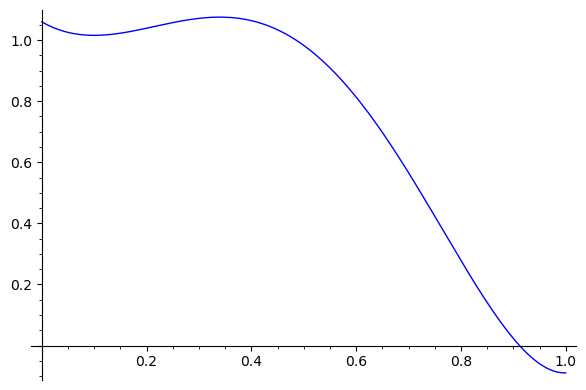

In [28]:
plot(3.89917344*t^5 + 0.30315056*t^4 - 10.94027034*t^3 + 6.57939732*t^2 - 0.99042814*t + 1.05944373, 0,1)

There's definitely a hump now. I think my next step should be to set `goal = 0.25` and `meridian = tau/4` to see
if I get the hemisphere. But I seem to remember that the geodesics didn't reach all the way.